# Init

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%env IMAGE_FORMAT=png
%env DATASET=merged_datasets_k16-NORM
%env DRIVE_DATA_DIR=./gdrive/MyDrive/master-thesis
%env COLAB_DATA_DIR=data

env: IMAGE_FORMAT=png
env: DATASET=merged_datasets_k16-NORM
env: DRIVE_DATA_DIR=./gdrive/MyDrive/master-thesis
env: COLAB_DATA_DIR=data


# Loading images from drive

In [ ]:
%%shell

rm -rf $COLAB_DATA_DIR
mkdir $COLAB_DATA_DIR

In [ ]:
! cp $DRIVE_DATA_DIR/$DATASET.${IMAGE_FORMAT}.zip $COLAB_DATA_DIR

In [ ]:
! sha1sum $COLAB_DATA_DIR/$DATASET.${IMAGE_FORMAT}.zip

69375cb4f07f173bcfa99a3473ad1250ffc37ae5  data/merged_datasets_k16-NORM.png.zip


In [ ]:
! unzip $COLAB_DATA_DIR/$DATASET.${IMAGE_FORMAT}.zip -d . && rm $COLAB_DATA_DIR/$DATASET.${IMAGE_FORMAT}.zip

Streaming output truncated to the last 5000 lines.
 extracting: ./data/merged_datasets/ADIPOSE/ADI-FICRTDDF.png  
 extracting: ./data/merged_datasets/ADIPOSE/ADI-CIMLQGTV.png  
 extracting: ./data/merged_datasets/ADIPOSE/ADI-ARGAPGLY.png  
 extracting: ./data/merged_datasets/ADIPOSE/ADI-PEYKHCDA.png  
 extracting: ./data/merged_datasets/ADIPOSE/ADI-NESCYVWI.png  
 extracting: ./data/merged_datasets/ADIPOSE/ADI-PQWRMKSK.png  
 extracting: ./data/merged_datasets/ADIPOSE/146AC_CRC-Prim-HE-03_012.tif_Row_3151_Col_451.png  
 extracting: ./data/merged_datasets/ADIPOSE/ADI-SCLCFMTW.png  
 extracting: ./data/merged_datasets/ADIPOSE/ADI-APLGRGCC.png  
 extracting: ./data/merged_datasets/ADIPOSE/ADI-RACSSMPP.png  
 extracting: ./data/merged_datasets/ADIPOSE/ADI-GCMYHMVF.png  
 extracting: ./data/merged_datasets/ADIPOSE/ADI-IYFCAWQM.png  
 extracting: ./data/merged_datasets/ADIPOSE/ADI-DMQFFPIR.png  
 extracting: ./data/merged_datasets/ADIPOSE/ADI-EDGVKAYQ.png  
 extracting: ./data/merged_dataset

In [ ]:
! mv $COLAB_DATA_DIR/merged_datasets $COLAB_DATA_DIR/$DATASET

In [ ]:
%%shell

find $COLAB_DATA_DIR/$DATASET -maxdepth 1 -type d | while read -r dir
do printf "%s:\t" "$dir"; find "$dir" -type f | wc -l; done

# Predicting algorithm time

In [ ]:
import statistics

epoch_count_1=5
epoch_count_2=5

phase_1_elapsed_ms = [48,53,35,34,33,33,32,31,33,32]
phase_2_elapsed_ms = [60, 69, 61, 63, 63, 64, 60, 60, 64, 63]
sec_per_batch_phase_1 = statistics.mean(phase_1_elapsed_ms[:epoch_count_1])/1000
sec_per_batch_phase_2 = statistics.mean(phase_2_elapsed_ms[:epoch_count_2])/1000

def printTrainTime(total_batch_count):
  print(f"{(((total_batch_count*(((sec_per_batch_phase_1)*epoch_count_1)+((sec_per_batch_phase_2)*epoch_count_2)))/60)/60):.2f} h")

## Exection time for Version 2 - test shared inside single division

In [ ]:
# dataset_sm_count = 5000 - 2 * 625
N_min = 1
balanced_size = 9504*9

balanced_batch_count = balanced_size//32 + (balanced_size % 32 > 0)


K = [
    k
    for len in range(balanced_size)
    for k in range(40)
    if (k + 0.2) * len == balanced_size
]

iterations_max = N_min * K[0]


print(f"Batches in total dataset {balanced_size//32}")
print(f"Factors of {balanced_size}, >= {K[0]} = |{len(K)}|:\t {K}\n")

batch_number=0

for k in K:

    iterations=iterations_max/k # Koliko puta trebamo iterirati kroz citavi dataset?
    batches=balanced_batch_count*iterations
    batch_number+=batches

    print(f"""\
    k = {k:2.0f} => ({k:2.0f} + 0.2) x {(balanced_size//(k+0.2)):5.0f} = {k*(balanced_size//k)}\
    Iterations: {(iterations_max//k):2.0f}\tExtra runs: {(iterations_max%k):2.0f}\t Batches: {batches:5.1f}\
    """)



print("Total batches to fit: ",batch_number//1)

printTrainTime(batch_number)

Batches in total dataset 2673
Factors of 85536, >= 35 = |8|:	 [35, 19, 16, 13, 7, 3, 2, 1]

    k = 35 => (35 + 0.2) x  2429 = 85505    Iterations:  1	Extra runs:  0	 Batches: 2673.0    
    k = 19 => (19 + 0.2) x  4455 = 85519    Iterations:  1	Extra runs: 16	 Batches: 4923.9    
    k = 16 => (16 + 0.2) x  5280 = 85536    Iterations:  2	Extra runs:  3	 Batches: 5847.2    
    k = 13 => (13 + 0.2) x  6480 = 85527    Iterations:  2	Extra runs:  9	 Batches: 7196.5    
    k =  7 => ( 7 + 0.2) x 11879 = 85533    Iterations:  5	Extra runs:  0	 Batches: 13365.0    
    k =  3 => ( 3 + 0.2) x 26729 = 85536    Iterations: 11	Extra runs:  2	 Batches: 31185.0    
    k =  2 => ( 2 + 0.2) x 38879 = 85536    Iterations: 17	Extra runs:  1	 Batches: 46777.5    
    k =  1 => ( 1 + 0.2) x 71280 = 85536    Iterations: 35	Extra runs:  0	 Batches: 93555.0    
Total batches to fit:  205523.0
29.63 h


## Execution time for Version 3 - separate test for each partition

In [ ]:
import statistics

epoch_count_1=5
epoch_count_2=5

phase_1_elapsed_ms = [48,53,35,34,33,33,32,31,33,32]
phase_2_elapsed_ms = [60, 69, 61, 63, 63, 64, 60, 60, 64, 63]
sec_per_batch_phase_1 = statistics.mean(phase_1_elapsed_ms[:epoch_count_1])/1000
sec_per_batch_phase_2 = statistics.mean(phase_2_elapsed_ms[:epoch_count_2])/1000

get_all_divisors_less_than = (
    lambda k_max, n: sorted(set([
        i for d in (
            [i]
            for i in range(1, min(int(k_max**0.5) + 1, n + 1))
            if k_max % i == 0
            )
            for i in d
        ]), reverse = True)
)

dataset_sm_count = 5000 - 2 * 625
N_min = 1
da_balanced_count = 9504*9

da_balanced_batch_count = da_balanced_count//32 + (da_balanced_count % 32 > 0)
k_max = da_balanced_count//dataset_sm_count
K = get_all_divisors_less_than(da_balanced_count,k_max)
iterations_max = N_min*K[0]

print(f"Batches in total dataset {da_balanced_batch_count}")
print(f"k_max = round({da_balanced_count} / {dataset_sm_count}) = {k_max}")
print(f"Factors of {da_balanced_count}, >= {k_max} = |{len(K)}|:\t", K, "\n")

batch_number=0

for k in K:
    iterations=iterations_max/k # Koliko puta trebamo iterirati kroz citavi dataset?
    batches=da_balanced_batch_count*iterations
    batch_number+=batches
    print(f"""\
    k = {k:2.0f} => {k:2.0f} x {(da_balanced_count//k):5.0f} = {k*(da_balanced_count//k)}\
    Iterations: {(iterations_max//k):2.0f}\tExtra runs: {(iterations_max%k):2.0f}\t Batches: {batches:5.1f}\
    """)

print("Total batches to fit: ",batch_number//1)

printTrainTime(batch_number)

Batches in total dataset 2673
k_max = round(85536 / 3750) = 22
Factors of 85536, >= 22 = |12|:	 [22, 18, 16, 12, 11, 9, 8, 6, 4, 3, 2, 1] 

    k = 22 => 22 x  3888 = 85536    Iterations:  1	Extra runs:  0	 Batches: 2673.0    
    k = 18 => 18 x  4752 = 85536    Iterations:  1	Extra runs:  4	 Batches: 3267.0    
    k = 16 => 16 x  5346 = 85536    Iterations:  1	Extra runs:  6	 Batches: 3675.4    
    k = 12 => 12 x  7128 = 85536    Iterations:  1	Extra runs: 10	 Batches: 4900.5    
    k = 11 => 11 x  7776 = 85536    Iterations:  2	Extra runs:  0	 Batches: 5346.0    
    k =  9 =>  9 x  9504 = 85536    Iterations:  2	Extra runs:  4	 Batches: 6534.0    
    k =  8 =>  8 x 10692 = 85536    Iterations:  2	Extra runs:  6	 Batches: 7350.8    
    k =  6 =>  6 x 14256 = 85536    Iterations:  3	Extra runs:  4	 Batches: 9801.0    
    k =  4 =>  4 x 21384 = 85536    Iterations:  5	Extra runs:  2	 Batches: 14701.5    
    k =  3 =>  3 x 28512 = 85536    Iterations:  7	Extra runs:  1	 Batches: 

# Iterative V1 - Single test set

Execute in order:
1. Scripts
2. Init (only if dataset is loaded)
3. Analyzing the results

## Scripts

In [ ]:
%%writefile model_builder.py

import keras


def create_model_and_train(
    train_ds,
    test_ds,
    image_size,
    epoch_counts,
    phase_1_optimizer,
    phase_2_optimizer,
    number_of_classes,
):
    keras.backend.clear_session()

    base_model = keras.applications.MobileNetV2(
        weights="imagenet",
        input_shape=(image_size[0], image_size[1], 3),
        include_top=False,
        alpha=1.0,
    )

    base_model.trainable = False
    inputs = keras.Input(shape=(image_size[0], image_size[1], 3))
    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(inputs)
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(number_of_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=phase_1_optimizer(), loss=keras.losses.sparse_categorical_crossentropy
    )

    model.fit(train_ds, epochs=epoch_counts[0], verbose=2)

    base_model.trainable = True
    model.compile(
        optimizer=phase_2_optimizer(), loss=keras.losses.sparse_categorical_crossentropy
    )

    model.fit(train_ds, epochs=epoch_counts[1], verbose=2)

    model.compile(
        optimizer=phase_2_optimizer(),
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=["accuracy"],
    )

    acc = model.evaluate(test_ds, verbose=2, return_dict=True)["accuracy"]

    del model

    return acc

Writing model_builder.py


In [ ]:
%%writefile save.py

import os
import pandas as pd

def saveResults(iteration, partition_count, partition, seed, accuracy, file_path):
    metrics = {
        "iteration": [iteration],
        "partition_count": [partition_count],
        "partition": [partition],
        "seed": [seed],
        "accuracy": [accuracy],
    }

    df = pd.DataFrame(data=metrics)

    df.to_csv(file_path, mode="a", header=not os.path.exists(file_path), index=False)


def loadResults(file_path):
    return pd.read_csv(file_path)

def deleteResults(file_path):
    metrics = {
        "iteration": [],
        "partition_count": [],
        "partition": [],
        "seed": [],
        "accuracy": [],
    }

    df = pd.DataFrame(data=metrics)

    df.to_csv(file_path, mode="w", index=False)


# Test
if __name__ == "__main__":
    deleteResults("test.csv")

    saveResults(0, 5, 1, 1234, 0.4534, "test.csv")
    saveResults(0, 5, 2, 1234, 0.4534, "test.csv")
    saveResults(0, 5, 3, 1234, 0.4534, "test.csv")
    saveResults(0, 5, 4, 1234, 0.4534, "test.csv")
    saveResults(0, 5, 5, 1234, 0.4534, "test.csv")
    saveResults(0, 5, 6, 1234, 0.4534, "test.csv")

    df = loadResults("test.csv")
    df


Writing save.py


In [ ]:
%%writefile helper.py

def get_all_divisors_less_than(k_max, n):
    return sorted(
        set(
            [
                i
                for d in (
                    [i]
                    for i in range(1, min(int(k_max**0.5) + 1, n + 1))
                    if k_max % i == 0
                )
                for i in d
            ]
        ),
        reverse=True,
    )

Writing helper.py


In [ ]:
%%writefile directory_balancer.py

import os
import random
import shutil
from copy import deepcopy


class DirectoryInfo:
    def __init__(self, source_dir):
        self.source_dir = source_dir
        self.sub_dirs = [
            sub_dir
            for sub_dir in os.listdir(source_dir)
            if os.path.isdir(os.path.join(source_dir, sub_dir))
        ]
        self.files, self.file_counts = self._explore_subdirs()
        self.number_of_classes = len(self.file_counts)
        # after balancing each class has equal No. of samples
        self.balanced_class_size = min(self.file_counts.values())
        # total number of samples in balanced dataset
        self.balanced_size = self.balanced_class_size * self.number_of_classes

    def _explore_subdirs(self):
        file_counts = {}
        files = {}
        for sub_dir in self.sub_dirs:
            sub_dir_path = os.path.join(self.source_dir, sub_dir)
            files[sub_dir] = os.listdir(sub_dir_path)
            file_counts[sub_dir] = len(files[sub_dir])
        return files, file_counts


def omitSamples(dataset_info, seed_omit=None, samples_omit=0):
    new_dataset_info = deepcopy(dataset_info)

    if samples_omit > dataset_info.balanced_size:
        raise ValueError(
            "samples_omit is larger than balanced dataset, {samples_omit} > {dataset_info.balanced_size}"
        )

    samples_omit_per_class = samples_omit // dataset_info.number_of_classes

    for sub_dir in dataset_info.sub_dirs:
        new_dataset_info.files[sub_dir] = [
            x
            for x in dataset_info.files[sub_dir]
            if x
            not in set(
                random.Random(seed_omit).sample(
                    dataset_info.files[sub_dir], samples_omit_per_class
                )
            )
        ]

    return new_dataset_info


def createSubset(
    dataset_info, destination_dir, seed, take_samples, skip_samples, action="copy"
):
    random_local = random.Random(seed)

    if os.path.exists(destination_dir):
        shutil.rmtree(destination_dir)
    os.makedirs(destination_dir)

    if take_samples > dataset_info.balanced_size:
        raise ValueError("Test size is larger than balanced dataset")

    samples_per_class = take_samples // dataset_info.number_of_classes
    skip_samples_per_class = skip_samples // dataset_info.number_of_classes

    for sub_dir in dataset_info.sub_dirs:
        sub_dir_path = os.path.join(dataset_info.source_dir, sub_dir)
        destination_sub_dir = os.path.join(destination_dir, sub_dir)
        os.makedirs(destination_sub_dir)

        selected_files = random_local.sample(
            dataset_info.files[sub_dir], skip_samples_per_class + samples_per_class
        )[skip_samples_per_class:]

        # Copy selected files
        for file_name in selected_files:
            source_file_path = os.path.join(sub_dir_path, file_name)
            destination_file_path = os.path.join(destination_sub_dir, file_name)
            if action == "copy":
                shutil.copyfile(source_file_path, destination_file_path)
            elif action == "move":
                shutil.move(source_file_path, destination_file_path)
            else:
                raise ValueError("Invalid action {action}")

    return destination_dir


Writing directory_balancer.py


## Init

In [ ]:
! rm -rf test_set

In [ ]:
import keras
import os
import tensorflow as tf
import gc
import random

import save
import helper
import model_builder
from directory_balancer import DirectoryInfo, createSubset

gc.enable()
gc.isenabled()

########## Configuration part ##########

# - dimenzija testnog dataseta
test_set_size = 8568

# - direktorij merganog dataseta
dataset_dir = f"{os.environ['COLAB_DATA_DIR']}/{os.environ['DATASET']}/"

# ------- Optional configuration --------

image_size = 100, 100
N_min = 1  # Define minium number of iterations per division
split = 80  # Train / Test
epoch_counts = [5, 5]
seed = 123

results_dir = f"{os.environ['DRIVE_DATA_DIR']}/iterative_results/"

batch_size = 32
model_name = "MobileNetV2"
dataset_name = os.environ['DATASET']
image_format = "png"  # os.environ['IMAGE_FORMAT']

phase1optimizer = "RMSprop"
phase2optimizer = "RMSprop"


def phase_1_optimizer():
    return keras.optimizers.RMSprop()


def phase_2_optimizer():
    return keras.optimizers.RMSprop(1e-5)


######### Initialization part  #########

results_output = f"""\
{results_dir}\
{model_name}-{dataset_name}-\
{image_format}-{image_size[0]}x{image_size[1]}-\
{batch_size}-{phase1optimizer}+{phase2optimizer}-\
{split}:{100-split}-v1.csv"""

In [ ]:
original_dataset_info = DirectoryInfo(dataset_dir)


# Remove test set from dataset


print(f"""\
Dataset size after balancing = {original_dataset_info.balanced_size}
{test_set_size} of {original_dataset_info.balanced_size} = {(test_set_size/original_dataset_info.balanced_size)*100:.04f}% -> TEST SET
{original_dataset_info.balanced_size-test_set_size} of {original_dataset_info.balanced_size} = {((original_dataset_info.balanced_size-test_set_size)/original_dataset_info.balanced_size)*100:.04f}% -> TRAIN IMAGES
""")


subset_test = keras.utils.image_dataset_from_directory(
    createSubset(
        dataset_info=original_dataset_info,
        destination_dir="test_set",
        seed=seed,
        take_samples=test_set_size,
        skip_samples=0,
        action="move",
    ),
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=seed,
    crop_to_aspect_ratio=False,
)

del original_dataset_info

In [ ]:
dataset_info = DirectoryInfo(dataset_dir)
print(f"Dataset size after test set removal = {dataset_info.balanced_size}")


k_max = dataset_info.balanced_size // test_set_size  # Greatest dividor
K = helper.get_all_divisors_less_than(dataset_info.balanced_size, k_max)
iterations_max = N_min * K[0]

print(f"k_max = round({dataset_info.balanced_size} / {test_set_size}) = {k_max}")
print(f"Factors of {dataset_info.balanced_size}, <= {k_max} = |{len(K)}|:\t {K}\n")


for k in K:
    print(f"""\
    k = {k:2.0f} => {k:2.0f} x {(dataset_info.balanced_size//k):5.0f} = {k*(dataset_info.balanced_size//k)}\
    Iterations: {(iterations_max//k):2.0f} Extra remainder: {(iterations_max%k):2.0f}\
    """)


######### Train and test part  #########

random_local = random.Random(seed)
random_seeds = random_local.sample(range(0, 1000), iterations_max)
print(f"\nRandoms for iterations: {random_seeds}")

labels_count = tf.convert_to_tensor(
    dataset_info.number_of_classes, dtype=tf.int32
)  # https://stackoverflow.com/a/58973855/12108610

## Iterating

- Following code blocks were executed untill Colab terminates the runtime or VM goes out of RAM.
- If training stucked, probably runtime gone out of RAM
- If Colab terminated the runtime
- Or any else
- Copy following block code and set up the conditions in two commented `if` clasues to skip already done divisions/partitions, which can be seen in the log of current execution.

In [ ]:
for iteration, seed in zip(range(iterations_max), random_seeds):
    print(f"\033[92m #### Iteration {iteration} : seed {seed} #### \033[0m")
    # if iteration in range(6):
    #     print(f"Skipping partition count #{iteration}")
    #     continue

    for partition_count in K:
        # if partition_count in [22, 18, 16, 12, 11, 9, 8, 6, 4]:
        #   print(f"Skipping partition count {partition_count}")
        #   continue

        if iterations_max / partition_count > iteration:
            samples_per_partition = int(dataset_info.balanced_size / partition_count)

            print(
                f"partition_count: {partition_count}\tsamples_per_partition x partition_count = {samples_per_partition*partition_count} == {dataset_info.balanced_size} ? {samples_per_partition*partition_count == dataset_info.balanced_size}"
            )

            real_partition_count = (
                partition_count
                if iterations_max // partition_count > iteration
                else iterations_max % partition_count
            )

            for partition in range(real_partition_count):
                print(f"Partition {partition+1}/{partition_count}")

                # if partition_count == 3 and partition in [0]:
                #   print(f"Skipping partition count {partition_count} partition {partition}")
                #   continue

                print(
                    f"samples_per_partition = {samples_per_partition}, skip_samples = {partition * samples_per_partition}"
                )

                subset_train = keras.utils.image_dataset_from_directory(
                    createSubset(
                        dataset_info=dataset_info,
                        destination_dir="train_set",
                        seed=seed,
                        take_samples=samples_per_partition,
                        skip_samples=partition * samples_per_partition,
                    ),
                    labels="inferred",
                    label_mode="int",
                    color_mode="rgb",
                    batch_size=batch_size,
                    image_size=image_size,
                    shuffle=True,
                    seed=seed,
                    crop_to_aspect_ratio=False,
                )

                accuracy = model_builder.create_model_and_train(
                    subset_train,
                    subset_test,
                    image_size,
                    epoch_counts,
                    phase_1_optimizer,
                    phase_2_optimizer,
                    labels_count,
                )

                # train && evaluate
                save.saveResults(
                    iteration,
                    partition_count,
                    partition,
                    seed,
                    accuracy,
                    results_output,
                )


 #### Iteration 0 : seed 53 #### 
partition_count: 8	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/8
samples_per_partition = 9621, skip_samples = 0
Found 9621 files belonging to 9 classes.


Epoch 1/5
301/301 - 10s - loss: 0.7390 - 10s/epoch - 33ms/step
Epoch 2/5
301/301 - 5s - loss: 0.4521 - 5s/epoch - 18ms/step
Epoch 3/5
301/301 - 7s - loss: 0.3918 - 7s/epoch - 24ms/step
Epoch 4/5
301/301 - 5s - loss: 0.3493 - 5s/epoch - 18ms/step
Epoch 5/5
301/301 - 6s - loss: 0.3251 - 6s/epoch - 21ms/step
Epoch 1/5
301/301 - 39s - loss: 0.2833 - 39s/epoch - 128ms/step
Epoch 2/5
301/301 - 15s - loss: 0.2095 - 15s/epoch - 48ms/step
Epoch 3/5
301/301 - 15s - loss: 0.1632 - 15s/epoch - 49ms/step
Epoch 4/5
301/301 - 14s - loss: 0.1242 - 14s/epoch - 47ms/step
Epoch 5/5
301/301 - 14s - loss: 0.0933 - 14s/epoch - 46ms/step
268/268 - 11s - loss: 0.3201 - accuracy: 0.9123 - 11s/epoch - 39ms/step
Partition 2/8
samples_per_partition = 9621, skip_samples = 9621
Found 9621 files belonging to 9 classes.


Epoch 1/5
301/301 - 10s - loss: 0.7191 - 10s/epoch - 33ms/step
Epoch 2/5
301/301 - 5s - loss: 0.4405 - 5s/epoch - 18ms/step
Epoch 3/5
301/301 - 7s - loss: 0.3887 - 7s/epoch - 23ms/step
Epoch 4/5
301/301 - 7s - loss: 0.3473 - 7s/epoch - 24ms/step
Epoch 5/5
301/301 - 5s - loss: 0.3285 - 5s/epoch - 18ms/step
Epoch 1/5
301/301 - 28s - loss: 0.2764 - 28s/epoch - 93ms/step
Epoch 2/5
301/301 - 14s - loss: 0.2020 - 14s/epoch - 47ms/step
Epoch 3/5
301/301 - 14s - loss: 0.1459 - 14s/epoch - 47ms/step
Epoch 4/5
301/301 - 14s - loss: 0.1149 - 14s/epoch - 47ms/step
Epoch 5/5
301/301 - 14s - loss: 0.0868 - 14s/epoch - 48ms/step
268/268 - 7s - loss: 0.2903 - accuracy: 0.9185 - 7s/epoch - 26ms/step
Partition 3/8
samples_per_partition = 9621, skip_samples = 19242
Found 9621 files belonging to 9 classes.


Epoch 1/5
301/301 - 8s - loss: 0.7062 - 8s/epoch - 27ms/step
Epoch 2/5
301/301 - 7s - loss: 0.4201 - 7s/epoch - 25ms/step
Epoch 3/5
301/301 - 5s - loss: 0.3699 - 5s/epoch - 18ms/step
Epoch 4/5
301/301 - 8s - loss: 0.3405 - 8s/epoch - 25ms/step
Epoch 5/5
301/301 - 6s - loss: 0.3117 - 6s/epoch - 21ms/step
Epoch 1/5
301/301 - 28s - loss: 0.2854 - 28s/epoch - 94ms/step
Epoch 2/5
301/301 - 15s - loss: 0.1989 - 15s/epoch - 48ms/step
Epoch 3/5
301/301 - 14s - loss: 0.1558 - 14s/epoch - 47ms/step
Epoch 4/5
301/301 - 14s - loss: 0.1170 - 14s/epoch - 48ms/step
Epoch 5/5
301/301 - 14s - loss: 0.0935 - 14s/epoch - 47ms/step
268/268 - 7s - loss: 0.2850 - accuracy: 0.9210 - 7s/epoch - 27ms/step
Partition 4/8
samples_per_partition = 9621, skip_samples = 28863
Found 9621 files belonging to 9 classes.


Epoch 1/5
301/301 - 9s - loss: 0.6964 - 9s/epoch - 29ms/step
Epoch 2/5
301/301 - 6s - loss: 0.4413 - 6s/epoch - 20ms/step
Epoch 3/5
301/301 - 6s - loss: 0.3861 - 6s/epoch - 21ms/step
Epoch 4/5
301/301 - 5s - loss: 0.3508 - 5s/epoch - 18ms/step
Epoch 5/5
301/301 - 7s - loss: 0.3280 - 7s/epoch - 25ms/step
Epoch 1/5
301/301 - 29s - loss: 0.2930 - 29s/epoch - 96ms/step
Epoch 2/5
301/301 - 14s - loss: 0.2170 - 14s/epoch - 47ms/step
Epoch 3/5
301/301 - 14s - loss: 0.1597 - 14s/epoch - 47ms/step
Epoch 4/5
301/301 - 14s - loss: 0.1244 - 14s/epoch - 47ms/step
Epoch 5/5
301/301 - 14s - loss: 0.0965 - 14s/epoch - 48ms/step
268/268 - 6s - loss: 0.2848 - accuracy: 0.9192 - 6s/epoch - 23ms/step
Partition 5/8
samples_per_partition = 9621, skip_samples = 38484
Found 9621 files belonging to 9 classes.


Epoch 1/5
301/301 - 8s - loss: 0.7200 - 8s/epoch - 26ms/step
Epoch 2/5
301/301 - 7s - loss: 0.4473 - 7s/epoch - 24ms/step
Epoch 3/5
301/301 - 5s - loss: 0.3883 - 5s/epoch - 18ms/step
Epoch 4/5
301/301 - 7s - loss: 0.3554 - 7s/epoch - 25ms/step
Epoch 5/5
301/301 - 5s - loss: 0.3325 - 5s/epoch - 18ms/step
Epoch 1/5
301/301 - 28s - loss: 0.2889 - 28s/epoch - 93ms/step
Epoch 2/5
301/301 - 15s - loss: 0.2130 - 15s/epoch - 48ms/step
Epoch 3/5
301/301 - 14s - loss: 0.1641 - 14s/epoch - 47ms/step
Epoch 4/5
301/301 - 14s - loss: 0.1262 - 14s/epoch - 47ms/step
Epoch 5/5
301/301 - 14s - loss: 0.0965 - 14s/epoch - 47ms/step
268/268 - 8s - loss: 0.2781 - accuracy: 0.9206 - 8s/epoch - 30ms/step
Partition 6/8
samples_per_partition = 9621, skip_samples = 48105
Found 9621 files belonging to 9 classes.


Epoch 1/5
301/301 - 9s - loss: 0.7118 - 9s/epoch - 31ms/step
Epoch 2/5
301/301 - 6s - loss: 0.4510 - 6s/epoch - 19ms/step
Epoch 3/5
301/301 - 5s - loss: 0.3866 - 5s/epoch - 18ms/step
Epoch 4/5
301/301 - 7s - loss: 0.3478 - 7s/epoch - 25ms/step
Epoch 5/5
301/301 - 5s - loss: 0.3259 - 5s/epoch - 18ms/step
Epoch 1/5
301/301 - 29s - loss: 0.2917 - 29s/epoch - 95ms/step
Epoch 2/5
301/301 - 14s - loss: 0.2136 - 14s/epoch - 47ms/step
Epoch 3/5
301/301 - 14s - loss: 0.1670 - 14s/epoch - 47ms/step
Epoch 4/5
301/301 - 14s - loss: 0.1264 - 14s/epoch - 47ms/step
Epoch 5/5
301/301 - 14s - loss: 0.0979 - 14s/epoch - 48ms/step
268/268 - 8s - loss: 0.2670 - accuracy: 0.9194 - 8s/epoch - 29ms/step
Partition 7/8
samples_per_partition = 9621, skip_samples = 57726
Found 9621 files belonging to 9 classes.


Epoch 1/5
301/301 - 10s - loss: 0.6925 - 10s/epoch - 32ms/step
Epoch 2/5
301/301 - 7s - loss: 0.4308 - 7s/epoch - 25ms/step
Epoch 3/5
301/301 - 5s - loss: 0.3755 - 5s/epoch - 18ms/step
Epoch 4/5
301/301 - 8s - loss: 0.3403 - 8s/epoch - 25ms/step
Epoch 5/5
301/301 - 5s - loss: 0.3155 - 5s/epoch - 18ms/step
Epoch 1/5
301/301 - 28s - loss: 0.2846 - 28s/epoch - 93ms/step
Epoch 2/5
301/301 - 14s - loss: 0.2117 - 14s/epoch - 47ms/step
Epoch 3/5
301/301 - 14s - loss: 0.1591 - 14s/epoch - 48ms/step
Epoch 4/5
301/301 - 14s - loss: 0.1204 - 14s/epoch - 47ms/step
Epoch 5/5
301/301 - 14s - loss: 0.0928 - 14s/epoch - 47ms/step
268/268 - 8s - loss: 0.2911 - accuracy: 0.9178 - 8s/epoch - 31ms/step
Partition 8/8
samples_per_partition = 9621, skip_samples = 67347
Found 9621 files belonging to 9 classes.


Epoch 1/5
301/301 - 9s - loss: 0.7129 - 9s/epoch - 29ms/step
Epoch 2/5
301/301 - 7s - loss: 0.4338 - 7s/epoch - 24ms/step
Epoch 3/5
301/301 - 6s - loss: 0.3864 - 6s/epoch - 18ms/step
Epoch 4/5
301/301 - 6s - loss: 0.3489 - 6s/epoch - 19ms/step
Epoch 5/5
301/301 - 5s - loss: 0.3305 - 5s/epoch - 18ms/step
Epoch 1/5
301/301 - 29s - loss: 0.2910 - 29s/epoch - 96ms/step
Epoch 2/5
301/301 - 14s - loss: 0.2153 - 14s/epoch - 48ms/step
Epoch 3/5
301/301 - 14s - loss: 0.1648 - 14s/epoch - 47ms/step
Epoch 4/5
301/301 - 14s - loss: 0.1222 - 14s/epoch - 48ms/step
Epoch 5/5
301/301 - 14s - loss: 0.0989 - 14s/epoch - 47ms/step
268/268 - 7s - loss: 0.2925 - accuracy: 0.9173 - 7s/epoch - 26ms/step
partition_count: 6	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/6
samples_per_partition = 12828, skip_samples = 0
Found 12825 files belonging to 9 classes.


Epoch 1/5
401/401 - 12s - loss: 0.6594 - 12s/epoch - 29ms/step
Epoch 2/5
401/401 - 8s - loss: 0.4200 - 8s/epoch - 19ms/step
Epoch 3/5
401/401 - 9s - loss: 0.3813 - 9s/epoch - 23ms/step
Epoch 4/5
401/401 - 7s - loss: 0.3450 - 7s/epoch - 18ms/step
Epoch 5/5
401/401 - 7s - loss: 0.3247 - 7s/epoch - 18ms/step
Epoch 1/5
401/401 - 34s - loss: 0.2866 - 34s/epoch - 85ms/step
Epoch 2/5
401/401 - 18s - loss: 0.2062 - 18s/epoch - 46ms/step
Epoch 3/5
401/401 - 19s - loss: 0.1567 - 19s/epoch - 47ms/step
Epoch 4/5
401/401 - 18s - loss: 0.1237 - 18s/epoch - 46ms/step
Epoch 5/5
401/401 - 20s - loss: 0.0950 - 20s/epoch - 49ms/step
268/268 - 6s - loss: 0.2456 - accuracy: 0.9239 - 6s/epoch - 23ms/step
Partition 2/6
samples_per_partition = 12828, skip_samples = 12828
Found 12825 files belonging to 9 classes.


Epoch 1/5
401/401 - 12s - loss: 0.6805 - 12s/epoch - 30ms/step
Epoch 2/5
401/401 - 8s - loss: 0.4286 - 8s/epoch - 19ms/step
Epoch 3/5
401/401 - 7s - loss: 0.3800 - 7s/epoch - 18ms/step
Epoch 4/5
401/401 - 8s - loss: 0.3538 - 8s/epoch - 20ms/step
Epoch 5/5
401/401 - 9s - loss: 0.3298 - 9s/epoch - 23ms/step
Epoch 1/5
401/401 - 32s - loss: 0.2847 - 32s/epoch - 80ms/step
Epoch 2/5
401/401 - 18s - loss: 0.2042 - 18s/epoch - 46ms/step
Epoch 3/5
401/401 - 21s - loss: 0.1544 - 21s/epoch - 52ms/step
Epoch 4/5
401/401 - 19s - loss: 0.1137 - 19s/epoch - 47ms/step
Epoch 5/5
401/401 - 20s - loss: 0.0917 - 20s/epoch - 50ms/step
268/268 - 7s - loss: 0.3067 - accuracy: 0.9109 - 7s/epoch - 25ms/step
Partition 3/6
samples_per_partition = 12828, skip_samples = 25656
Found 12825 files belonging to 9 classes.


Epoch 1/5
401/401 - 13s - loss: 0.6763 - 13s/epoch - 33ms/step
Epoch 2/5
401/401 - 7s - loss: 0.4213 - 7s/epoch - 18ms/step
Epoch 3/5
401/401 - 9s - loss: 0.3783 - 9s/epoch - 24ms/step
Epoch 4/5
401/401 - 8s - loss: 0.3482 - 8s/epoch - 19ms/step
Epoch 5/5
401/401 - 7s - loss: 0.3325 - 7s/epoch - 18ms/step
Epoch 1/5
401/401 - 34s - loss: 0.2832 - 34s/epoch - 85ms/step
Epoch 2/5
401/401 - 19s - loss: 0.2032 - 19s/epoch - 48ms/step
Epoch 3/5
401/401 - 19s - loss: 0.1536 - 19s/epoch - 46ms/step
Epoch 4/5
401/401 - 20s - loss: 0.1152 - 20s/epoch - 49ms/step
Epoch 5/5
401/401 - 19s - loss: 0.0953 - 19s/epoch - 47ms/step
268/268 - 8s - loss: 0.2449 - accuracy: 0.9302 - 8s/epoch - 29ms/step
Partition 4/6
samples_per_partition = 12828, skip_samples = 38484
Found 12825 files belonging to 9 classes.


Epoch 1/5
401/401 - 10s - loss: 0.6744 - 10s/epoch - 26ms/step
Epoch 2/5
401/401 - 10s - loss: 0.4280 - 10s/epoch - 24ms/step
Epoch 3/5
401/401 - 8s - loss: 0.3845 - 8s/epoch - 21ms/step
Epoch 4/5
401/401 - 8s - loss: 0.3484 - 8s/epoch - 21ms/step
Epoch 5/5
401/401 - 9s - loss: 0.3319 - 9s/epoch - 23ms/step
Epoch 1/5
401/401 - 33s - loss: 0.2817 - 33s/epoch - 82ms/step
Epoch 2/5
401/401 - 19s - loss: 0.2024 - 19s/epoch - 47ms/step
Epoch 3/5
401/401 - 20s - loss: 0.1581 - 20s/epoch - 50ms/step
Epoch 4/5
401/401 - 19s - loss: 0.1195 - 19s/epoch - 47ms/step
Epoch 5/5
401/401 - 20s - loss: 0.0916 - 20s/epoch - 50ms/step
268/268 - 6s - loss: 0.2419 - accuracy: 0.9268 - 6s/epoch - 24ms/step
Partition 5/6
samples_per_partition = 12828, skip_samples = 51312
Found 12825 files belonging to 9 classes.


Epoch 1/5
401/401 - 11s - loss: 0.6785 - 11s/epoch - 28ms/step
Epoch 2/5
401/401 - 9s - loss: 0.4345 - 9s/epoch - 21ms/step
Epoch 3/5
401/401 - 10s - loss: 0.3781 - 10s/epoch - 24ms/step
Epoch 4/5
401/401 - 9s - loss: 0.3420 - 9s/epoch - 22ms/step
Epoch 5/5
401/401 - 7s - loss: 0.3285 - 7s/epoch - 19ms/step
Epoch 1/5
401/401 - 34s - loss: 0.2864 - 34s/epoch - 84ms/step
Epoch 2/5
401/401 - 19s - loss: 0.2022 - 19s/epoch - 46ms/step
Epoch 3/5
401/401 - 18s - loss: 0.1509 - 18s/epoch - 46ms/step
Epoch 4/5
401/401 - 20s - loss: 0.1169 - 20s/epoch - 50ms/step
Epoch 5/5
401/401 - 19s - loss: 0.0891 - 19s/epoch - 47ms/step
268/268 - 8s - loss: 0.2723 - accuracy: 0.9224 - 8s/epoch - 28ms/step
Partition 6/6
samples_per_partition = 12828, skip_samples = 64140
Found 12825 files belonging to 9 classes.


Epoch 1/5
401/401 - 14s - loss: 0.6935 - 14s/epoch - 34ms/step
Epoch 2/5
401/401 - 10s - loss: 0.4276 - 10s/epoch - 25ms/step
Epoch 3/5
401/401 - 7s - loss: 0.3813 - 7s/epoch - 18ms/step
Epoch 4/5
401/401 - 10s - loss: 0.3481 - 10s/epoch - 24ms/step
Epoch 5/5
401/401 - 10s - loss: 0.3320 - 10s/epoch - 25ms/step
Epoch 1/5
401/401 - 33s - loss: 0.2856 - 33s/epoch - 83ms/step
Epoch 2/5
401/401 - 19s - loss: 0.2068 - 19s/epoch - 49ms/step
Epoch 3/5
401/401 - 19s - loss: 0.1522 - 19s/epoch - 49ms/step
Epoch 4/5
401/401 - 19s - loss: 0.1189 - 19s/epoch - 47ms/step
Epoch 5/5
401/401 - 20s - loss: 0.0913 - 20s/epoch - 50ms/step
268/268 - 6s - loss: 0.2617 - accuracy: 0.9285 - 6s/epoch - 23ms/step
partition_count: 4	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/4
samples_per_partition = 19242, skip_samples = 0
Found 19242 files belonging to 9 classes.


Epoch 1/5
602/602 - 16s - loss: 0.5872 - 16s/epoch - 27ms/step
Epoch 2/5
602/602 - 13s - loss: 0.4131 - 13s/epoch - 22ms/step
Epoch 3/5
602/602 - 13s - loss: 0.3680 - 13s/epoch - 21ms/step
Epoch 4/5
602/602 - 13s - loss: 0.3473 - 13s/epoch - 21ms/step
Epoch 5/5
602/602 - 13s - loss: 0.3329 - 13s/epoch - 21ms/step
Epoch 1/5
602/602 - 43s - loss: 0.2831 - 43s/epoch - 72ms/step
Epoch 2/5
602/602 - 29s - loss: 0.1979 - 29s/epoch - 48ms/step
Epoch 3/5
602/602 - 28s - loss: 0.1549 - 28s/epoch - 47ms/step
Epoch 4/5
602/602 - 28s - loss: 0.1161 - 28s/epoch - 47ms/step
Epoch 5/5
602/602 - 28s - loss: 0.0878 - 28s/epoch - 47ms/step
268/268 - 8s - loss: 0.2081 - accuracy: 0.9355 - 8s/epoch - 28ms/step
Partition 2/4
samples_per_partition = 19242, skip_samples = 19242
Found 19242 files belonging to 9 classes.


Epoch 1/5
602/602 - 16s - loss: 0.6038 - 16s/epoch - 26ms/step
Epoch 2/5
602/602 - 13s - loss: 0.4062 - 13s/epoch - 21ms/step
Epoch 3/5
602/602 - 13s - loss: 0.3646 - 13s/epoch - 22ms/step
Epoch 4/5
602/602 - 13s - loss: 0.3518 - 13s/epoch - 21ms/step
Epoch 5/5
602/602 - 13s - loss: 0.3338 - 13s/epoch - 21ms/step
Epoch 1/5
602/602 - 42s - loss: 0.2803 - 42s/epoch - 70ms/step
Epoch 2/5
602/602 - 28s - loss: 0.1974 - 28s/epoch - 47ms/step
Epoch 3/5
602/602 - 29s - loss: 0.1482 - 29s/epoch - 48ms/step
Epoch 4/5
602/602 - 29s - loss: 0.1152 - 29s/epoch - 48ms/step
Epoch 5/5
602/602 - 29s - loss: 0.0876 - 29s/epoch - 48ms/step
268/268 - 6s - loss: 0.2025 - accuracy: 0.9418 - 6s/epoch - 23ms/step
Partition 3/4
samples_per_partition = 19242, skip_samples = 38484
Found 19242 files belonging to 9 classes.


Epoch 1/5
602/602 - 16s - loss: 0.6077 - 16s/epoch - 26ms/step
Epoch 2/5
602/602 - 13s - loss: 0.4083 - 13s/epoch - 22ms/step
Epoch 3/5
602/602 - 13s - loss: 0.3703 - 13s/epoch - 21ms/step
Epoch 4/5
602/602 - 12s - loss: 0.3481 - 12s/epoch - 20ms/step
Epoch 5/5
602/602 - 11s - loss: 0.3362 - 11s/epoch - 19ms/step
Epoch 1/5
602/602 - 45s - loss: 0.2748 - 45s/epoch - 74ms/step
Epoch 2/5
602/602 - 28s - loss: 0.1976 - 28s/epoch - 47ms/step
Epoch 3/5
602/602 - 29s - loss: 0.1511 - 29s/epoch - 48ms/step
Epoch 4/5
602/602 - 29s - loss: 0.1151 - 29s/epoch - 48ms/step
Epoch 5/5
602/602 - 30s - loss: 0.0863 - 30s/epoch - 50ms/step
268/268 - 7s - loss: 0.2288 - accuracy: 0.9345 - 7s/epoch - 27ms/step
Partition 4/4
samples_per_partition = 19242, skip_samples = 57726
Found 19242 files belonging to 9 classes.


Epoch 1/5
602/602 - 15s - loss: 0.5965 - 15s/epoch - 25ms/step
Epoch 2/5
602/602 - 13s - loss: 0.4051 - 13s/epoch - 21ms/step
Epoch 3/5
602/602 - 13s - loss: 0.3715 - 13s/epoch - 21ms/step
Epoch 4/5
602/602 - 12s - loss: 0.3479 - 12s/epoch - 19ms/step
Epoch 5/5
602/602 - 12s - loss: 0.3381 - 12s/epoch - 20ms/step
Epoch 1/5
602/602 - 42s - loss: 0.2823 - 42s/epoch - 70ms/step
Epoch 2/5
602/602 - 29s - loss: 0.1995 - 29s/epoch - 48ms/step
Epoch 3/5
602/602 - 28s - loss: 0.1525 - 28s/epoch - 47ms/step
Epoch 4/5
602/602 - 28s - loss: 0.1162 - 28s/epoch - 47ms/step
Epoch 5/5
602/602 - 28s - loss: 0.0894 - 28s/epoch - 47ms/step
268/268 - 8s - loss: 0.2200 - accuracy: 0.9374 - 8s/epoch - 30ms/step
partition_count: 3	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/3
samples_per_partition = 25656, skip_samples = 0
Found 25650 files belonging to 9 classes.


Epoch 1/5
802/802 - 20s - loss: 0.5518 - 20s/epoch - 25ms/step
Epoch 2/5
802/802 - 18s - loss: 0.3942 - 18s/epoch - 22ms/step
Epoch 3/5
802/802 - 16s - loss: 0.3681 - 16s/epoch - 20ms/step
Epoch 4/5
802/802 - 16s - loss: 0.3517 - 16s/epoch - 20ms/step
Epoch 5/5
802/802 - 17s - loss: 0.3417 - 17s/epoch - 21ms/step
Epoch 1/5
802/802 - 52s - loss: 0.2759 - 52s/epoch - 65ms/step
Epoch 2/5
802/802 - 37s - loss: 0.1945 - 37s/epoch - 46ms/step
Epoch 3/5
802/802 - 38s - loss: 0.1444 - 38s/epoch - 48ms/step
Epoch 4/5
802/802 - 38s - loss: 0.1093 - 38s/epoch - 47ms/step
Epoch 5/5
802/802 - 37s - loss: 0.0850 - 37s/epoch - 46ms/step
268/268 - 7s - loss: 0.1992 - accuracy: 0.9434 - 7s/epoch - 26ms/step
Partition 2/3
samples_per_partition = 25656, skip_samples = 25656
Found 25650 files belonging to 9 classes.


Epoch 1/5
802/802 - 19s - loss: 0.5608 - 19s/epoch - 24ms/step
Epoch 2/5
802/802 - 18s - loss: 0.3951 - 18s/epoch - 22ms/step
Epoch 3/5
802/802 - 16s - loss: 0.3626 - 16s/epoch - 20ms/step
Epoch 4/5
802/802 - 18s - loss: 0.3471 - 18s/epoch - 22ms/step
Epoch 5/5
802/802 - 16s - loss: 0.3387 - 16s/epoch - 20ms/step
Epoch 1/5
802/802 - 52s - loss: 0.2755 - 52s/epoch - 65ms/step
Epoch 2/5
802/802 - 38s - loss: 0.1916 - 38s/epoch - 47ms/step
Epoch 3/5
802/802 - 38s - loss: 0.1415 - 38s/epoch - 48ms/step
Epoch 4/5
802/802 - 38s - loss: 0.1109 - 38s/epoch - 47ms/step
Epoch 5/5
802/802 - 38s - loss: 0.0850 - 38s/epoch - 48ms/step
268/268 - 7s - loss: 0.1998 - accuracy: 0.9455 - 7s/epoch - 25ms/step
Partition 3/3
samples_per_partition = 25656, skip_samples = 51312
Found 25650 files belonging to 9 classes.


Epoch 1/5
802/802 - 20s - loss: 0.5651 - 20s/epoch - 25ms/step
Epoch 2/5
802/802 - 16s - loss: 0.3957 - 16s/epoch - 20ms/step
Epoch 3/5
802/802 - 16s - loss: 0.3659 - 16s/epoch - 20ms/step
Epoch 4/5
802/802 - 16s - loss: 0.3572 - 16s/epoch - 20ms/step
Epoch 5/5
802/802 - 16s - loss: 0.3437 - 16s/epoch - 20ms/step
Epoch 1/5
802/802 - 55s - loss: 0.2787 - 55s/epoch - 69ms/step
Epoch 2/5
802/802 - 37s - loss: 0.1896 - 37s/epoch - 46ms/step
Epoch 3/5
802/802 - 38s - loss: 0.1419 - 38s/epoch - 47ms/step
Epoch 4/5
802/802 - 38s - loss: 0.1093 - 38s/epoch - 47ms/step
Epoch 5/5
802/802 - 37s - loss: 0.0858 - 37s/epoch - 46ms/step
268/268 - 6s - loss: 0.2072 - accuracy: 0.9376 - 6s/epoch - 23ms/step
partition_count: 2	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/2
samples_per_partition = 38484, skip_samples = 0
Found 38484 files belonging to 9 classes.


Epoch 1/5
1203/1203 - 40s - loss: 0.5194 - 40s/epoch - 33ms/step
Epoch 2/5
1203/1203 - 27s - loss: 0.3856 - 27s/epoch - 23ms/step
Epoch 3/5
1203/1203 - 25s - loss: 0.3683 - 25s/epoch - 21ms/step
Epoch 4/5
1203/1203 - 26s - loss: 0.3556 - 26s/epoch - 22ms/step
Epoch 5/5
1203/1203 - 25s - loss: 0.3468 - 25s/epoch - 21ms/step
Epoch 1/5
1203/1203 - 73s - loss: 0.2657 - 73s/epoch - 60ms/step
Epoch 2/5
1203/1203 - 58s - loss: 0.1756 - 58s/epoch - 48ms/step
Epoch 3/5
1203/1203 - 56s - loss: 0.1301 - 56s/epoch - 47ms/step
Epoch 4/5
1203/1203 - 57s - loss: 0.0983 - 57s/epoch - 47ms/step
Epoch 5/5
1203/1203 - 56s - loss: 0.0755 - 56s/epoch - 47ms/step
268/268 - 7s - loss: 0.1513 - accuracy: 0.9568 - 7s/epoch - 26ms/step
Partition 2/2
samples_per_partition = 38484, skip_samples = 38484
Found 38484 files belonging to 9 classes.


Epoch 1/5
1203/1203 - 39s - loss: 0.5214 - 39s/epoch - 32ms/step
Epoch 2/5
1203/1203 - 26s - loss: 0.3907 - 26s/epoch - 21ms/step
Epoch 3/5
1203/1203 - 24s - loss: 0.3693 - 24s/epoch - 20ms/step
Epoch 4/5
1203/1203 - 25s - loss: 0.3588 - 25s/epoch - 21ms/step
Epoch 5/5
1203/1203 - 24s - loss: 0.3510 - 24s/epoch - 20ms/step
Epoch 1/5
1203/1203 - 71s - loss: 0.2683 - 71s/epoch - 59ms/step
Epoch 2/5
1203/1203 - 56s - loss: 0.1809 - 56s/epoch - 47ms/step
Epoch 3/5
1203/1203 - 56s - loss: 0.1317 - 56s/epoch - 47ms/step
Epoch 4/5
1203/1203 - 56s - loss: 0.1000 - 56s/epoch - 47ms/step
Epoch 5/5
1203/1203 - 56s - loss: 0.0772 - 56s/epoch - 47ms/step
268/268 - 7s - loss: 0.1559 - accuracy: 0.9539 - 7s/epoch - 25ms/step
partition_count: 1	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/1
samples_per_partition = 76968, skip_samples = 0
Found 76968 files belonging to 9 classes.


Epoch 1/5
2406/2406 - 89s - loss: 0.4601 - 89s/epoch - 37ms/step
Epoch 2/5
2406/2406 - 54s - loss: 0.3723 - 54s/epoch - 23ms/step
Epoch 3/5
2406/2406 - 51s - loss: 0.3677 - 51s/epoch - 21ms/step
Epoch 4/5
2406/2406 - 52s - loss: 0.3660 - 52s/epoch - 22ms/step
Epoch 5/5
2406/2406 - 49s - loss: 0.3647 - 49s/epoch - 20ms/step
Epoch 1/5
2406/2406 - 128s - loss: 0.2362 - 128s/epoch - 53ms/step
Epoch 2/5
2406/2406 - 113s - loss: 0.1400 - 113s/epoch - 47ms/step
Epoch 3/5
2406/2406 - 113s - loss: 0.1008 - 113s/epoch - 47ms/step
Epoch 4/5
2406/2406 - 113s - loss: 0.0773 - 113s/epoch - 47ms/step
Epoch 5/5
2406/2406 - 113s - loss: 0.0604 - 113s/epoch - 47ms/step
268/268 - 18s - loss: 0.1061 - accuracy: 0.9657 - 18s/epoch - 68ms/step
 #### Iteration 1 : seed 274 #### 
partition_count: 6	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/6
samples_per_partition = 12828, skip_samples = 0


KeyboardInterrupt: 

In [ ]:
for iteration, seed in zip(range(iterations_max), random_seeds):
    print(f"\033[92m #### Iteration {iteration} : seed {seed} #### \033[0m")
    if iteration in range(1):
        print(f"Skipping partition count #{iteration}")
        continue

    for partition_count in K:
        # if partition_count in [22, 18, 16, 12, 11, 9, 8, 6, 4]:
        #   print(f"Skipping partition count {partition_count}")
        #   continue

        if iterations_max / partition_count > iteration:
            samples_per_partition = int(dataset_info.balanced_size / partition_count)

            print(
                f"partition_count: {partition_count}\tsamples_per_partition x partition_count = {samples_per_partition*partition_count} == {dataset_info.balanced_size} ? {samples_per_partition*partition_count == dataset_info.balanced_size}"
            )

            real_partition_count = (
                partition_count
                if iterations_max // partition_count > iteration
                else iterations_max % partition_count
            )

            for partition in range(real_partition_count):
                print(f"Partition {partition+1}/{partition_count}")

                # if partition_count == 3 and partition in [0]:
                #   print(f"Skipping partition count {partition_count} partition {partition}")
                #   continue

                print(
                    f"samples_per_partition = {samples_per_partition}, skip_samples = {partition * samples_per_partition}"
                )

                subset_train = keras.utils.image_dataset_from_directory(
                    createSubset(
                        dataset_info=dataset_info,
                        destination_dir="train_set",
                        seed=seed,
                        take_samples=samples_per_partition,
                        skip_samples=partition * samples_per_partition,
                    ),
                    labels="inferred",
                    label_mode="int",
                    color_mode="rgb",
                    batch_size=batch_size,
                    image_size=image_size,
                    shuffle=True,
                    seed=seed,
                    crop_to_aspect_ratio=False,
                )

                accuracy = model_builder.create_model_and_train(
                    subset_train,
                    subset_test,
                    image_size,
                    epoch_counts,
                    phase_1_optimizer,
                    phase_2_optimizer,
                    labels_count,
                )

                # train && evaluate
                save.saveResults(
                    iteration,
                    partition_count,
                    partition,
                    seed,
                    accuracy,
                    results_output,
                )


 #### Iteration 0 : seed 53 #### 
Skipping partition count #0
 #### Iteration 1 : seed 274 #### 
partition_count: 6	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/6
samples_per_partition = 12828, skip_samples = 0
Found 12825 files belonging to 9 classes.


Epoch 1/5
401/401 - 15s - loss: 0.6488 - 15s/epoch - 38ms/step
Epoch 2/5
401/401 - 9s - loss: 0.4122 - 9s/epoch - 23ms/step
Epoch 3/5
401/401 - 8s - loss: 0.3726 - 8s/epoch - 19ms/step
Epoch 4/5
401/401 - 7s - loss: 0.3446 - 7s/epoch - 18ms/step
Epoch 5/5
401/401 - 10s - loss: 0.3262 - 10s/epoch - 25ms/step
Epoch 1/5
401/401 - 37s - loss: 0.2844 - 37s/epoch - 92ms/step
Epoch 2/5
401/401 - 19s - loss: 0.2015 - 19s/epoch - 47ms/step
Epoch 3/5
401/401 - 19s - loss: 0.1531 - 19s/epoch - 46ms/step
Epoch 4/5
401/401 - 20s - loss: 0.1180 - 20s/epoch - 49ms/step
Epoch 5/5
401/401 - 19s - loss: 0.0894 - 19s/epoch - 46ms/step
268/268 - 11s - loss: 0.2816 - accuracy: 0.9194 - 11s/epoch - 40ms/step
Partition 2/6
samples_per_partition = 12828, skip_samples = 12828
Found 12825 files belonging to 9 classes.


Epoch 1/5
401/401 - 12s - loss: 0.6616 - 12s/epoch - 31ms/step
Epoch 2/5
401/401 - 7s - loss: 0.4196 - 7s/epoch - 18ms/step
Epoch 3/5
401/401 - 7s - loss: 0.3748 - 7s/epoch - 18ms/step
Epoch 4/5
401/401 - 9s - loss: 0.3474 - 9s/epoch - 23ms/step
Epoch 5/5
401/401 - 8s - loss: 0.3304 - 8s/epoch - 20ms/step
Epoch 1/5
401/401 - 33s - loss: 0.2828 - 33s/epoch - 83ms/step
Epoch 2/5
401/401 - 19s - loss: 0.2120 - 19s/epoch - 48ms/step
Epoch 3/5
401/401 - 19s - loss: 0.1584 - 19s/epoch - 48ms/step
Epoch 4/5
401/401 - 19s - loss: 0.1281 - 19s/epoch - 47ms/step
Epoch 5/5
401/401 - 20s - loss: 0.0963 - 20s/epoch - 51ms/step
268/268 - 6s - loss: 0.2636 - accuracy: 0.9283 - 6s/epoch - 23ms/step
partition_count: 4	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/4
samples_per_partition = 19242, skip_samples = 0
Found 19242 files belonging to 9 classes.


Epoch 1/5
602/602 - 16s - loss: 0.5898 - 16s/epoch - 27ms/step
Epoch 2/5
602/602 - 13s - loss: 0.4056 - 13s/epoch - 22ms/step
Epoch 3/5
602/602 - 12s - loss: 0.3757 - 12s/epoch - 20ms/step
Epoch 4/5
602/602 - 13s - loss: 0.3525 - 13s/epoch - 22ms/step
Epoch 5/5
602/602 - 13s - loss: 0.3400 - 13s/epoch - 22ms/step
Epoch 1/5
602/602 - 44s - loss: 0.2774 - 44s/epoch - 72ms/step
Epoch 2/5
602/602 - 29s - loss: 0.1936 - 29s/epoch - 48ms/step
Epoch 3/5
602/602 - 29s - loss: 0.1480 - 29s/epoch - 48ms/step
Epoch 4/5
602/602 - 29s - loss: 0.1175 - 29s/epoch - 48ms/step
Epoch 5/5
602/602 - 29s - loss: 0.0893 - 29s/epoch - 48ms/step
268/268 - 6s - loss: 0.2207 - accuracy: 0.9339 - 6s/epoch - 24ms/step
Partition 2/4
samples_per_partition = 19242, skip_samples = 19242
Found 19242 files belonging to 9 classes.


Epoch 1/5
602/602 - 15s - loss: 0.5956 - 15s/epoch - 26ms/step
Epoch 2/5
602/602 - 13s - loss: 0.4088 - 13s/epoch - 22ms/step
Epoch 3/5
602/602 - 13s - loss: 0.3677 - 13s/epoch - 22ms/step
Epoch 4/5
602/602 - 12s - loss: 0.3523 - 12s/epoch - 19ms/step
Epoch 5/5
602/602 - 13s - loss: 0.3399 - 13s/epoch - 22ms/step
Epoch 1/5
602/602 - 44s - loss: 0.2814 - 44s/epoch - 73ms/step
Epoch 2/5
602/602 - 29s - loss: 0.1974 - 29s/epoch - 49ms/step
Epoch 3/5
602/602 - 29s - loss: 0.1503 - 29s/epoch - 48ms/step
Epoch 4/5
602/602 - 29s - loss: 0.1142 - 29s/epoch - 48ms/step
Epoch 5/5
602/602 - 29s - loss: 0.0863 - 29s/epoch - 48ms/step
268/268 - 6s - loss: 0.2147 - accuracy: 0.9377 - 6s/epoch - 24ms/step
Partition 3/4
samples_per_partition = 19242, skip_samples = 38484
Found 19242 files belonging to 9 classes.


Epoch 1/5
602/602 - 15s - loss: 0.5998 - 15s/epoch - 26ms/step
Epoch 2/5
602/602 - 13s - loss: 0.4085 - 13s/epoch - 22ms/step
Epoch 3/5
602/602 - 13s - loss: 0.3662 - 13s/epoch - 22ms/step
Epoch 4/5
602/602 - 12s - loss: 0.3496 - 12s/epoch - 20ms/step
Epoch 5/5
602/602 - 13s - loss: 0.3326 - 13s/epoch - 21ms/step
Epoch 1/5
602/602 - 43s - loss: 0.2786 - 43s/epoch - 72ms/step
Epoch 2/5
602/602 - 29s - loss: 0.1969 - 29s/epoch - 48ms/step
Epoch 3/5
602/602 - 29s - loss: 0.1448 - 29s/epoch - 48ms/step
Epoch 4/5
602/602 - 28s - loss: 0.1118 - 28s/epoch - 47ms/step
Epoch 5/5
602/602 - 30s - loss: 0.0866 - 30s/epoch - 49ms/step
268/268 - 6s - loss: 0.2190 - accuracy: 0.9357 - 6s/epoch - 23ms/step
Partition 4/4
samples_per_partition = 19242, skip_samples = 57726
Found 19242 files belonging to 9 classes.


Epoch 1/5
602/602 - 16s - loss: 0.5932 - 16s/epoch - 26ms/step
Epoch 2/5
602/602 - 13s - loss: 0.4065 - 13s/epoch - 22ms/step
Epoch 3/5
602/602 - 13s - loss: 0.3729 - 13s/epoch - 22ms/step
Epoch 4/5
602/602 - 13s - loss: 0.3483 - 13s/epoch - 22ms/step
Epoch 5/5
602/602 - 13s - loss: 0.3344 - 13s/epoch - 22ms/step
Epoch 1/5
602/602 - 43s - loss: 0.2836 - 43s/epoch - 72ms/step
Epoch 2/5
602/602 - 29s - loss: 0.2013 - 29s/epoch - 48ms/step
Epoch 3/5
602/602 - 29s - loss: 0.1527 - 29s/epoch - 47ms/step
Epoch 4/5
602/602 - 29s - loss: 0.1208 - 29s/epoch - 47ms/step
Epoch 5/5
602/602 - 29s - loss: 0.0918 - 29s/epoch - 48ms/step
268/268 - 8s - loss: 0.2089 - accuracy: 0.9387 - 8s/epoch - 31ms/step
partition_count: 3	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/3
samples_per_partition = 25656, skip_samples = 0
Found 25650 files belonging to 9 classes.


Epoch 1/5
802/802 - 21s - loss: 0.5549 - 21s/epoch - 27ms/step
Epoch 2/5
802/802 - 17s - loss: 0.3944 - 17s/epoch - 21ms/step
Epoch 3/5
802/802 - 17s - loss: 0.3650 - 17s/epoch - 21ms/step
Epoch 4/5
802/802 - 17s - loss: 0.3496 - 17s/epoch - 21ms/step
Epoch 5/5
802/802 - 17s - loss: 0.3407 - 17s/epoch - 21ms/step
Epoch 1/5
802/802 - 55s - loss: 0.2779 - 55s/epoch - 69ms/step
Epoch 2/5
802/802 - 38s - loss: 0.1944 - 38s/epoch - 48ms/step
Epoch 3/5
802/802 - 39s - loss: 0.1480 - 39s/epoch - 48ms/step
Epoch 4/5
802/802 - 40s - loss: 0.1116 - 40s/epoch - 50ms/step
Epoch 5/5
802/802 - 39s - loss: 0.0842 - 39s/epoch - 49ms/step
268/268 - 6s - loss: 0.1832 - accuracy: 0.9443 - 6s/epoch - 23ms/step
Partition 2/3
samples_per_partition = 25656, skip_samples = 25656
Found 25650 files belonging to 9 classes.


Epoch 1/5
802/802 - 21s - loss: 0.5494 - 21s/epoch - 26ms/step
Epoch 2/5
802/802 - 17s - loss: 0.3884 - 17s/epoch - 21ms/step
Epoch 3/5
802/802 - 17s - loss: 0.3612 - 17s/epoch - 21ms/step
Epoch 4/5
802/802 - 17s - loss: 0.3467 - 17s/epoch - 21ms/step
Epoch 5/5
802/802 - 19s - loss: 0.3332 - 19s/epoch - 24ms/step
Epoch 1/5
802/802 - 52s - loss: 0.2712 - 52s/epoch - 64ms/step
Epoch 2/5
802/802 - 39s - loss: 0.1854 - 39s/epoch - 49ms/step
Epoch 3/5
802/802 - 41s - loss: 0.1377 - 41s/epoch - 51ms/step
Epoch 4/5
802/802 - 39s - loss: 0.1054 - 39s/epoch - 48ms/step
Epoch 5/5
802/802 - 38s - loss: 0.0796 - 38s/epoch - 48ms/step
268/268 - 6s - loss: 0.2087 - accuracy: 0.9390 - 6s/epoch - 23ms/step
Partition 3/3
samples_per_partition = 25656, skip_samples = 51312
Found 25650 files belonging to 9 classes.


Epoch 1/5
802/802 - 22s - loss: 0.5584 - 22s/epoch - 27ms/step
Epoch 2/5
802/802 - 17s - loss: 0.4045 - 17s/epoch - 21ms/step
Epoch 3/5
802/802 - 16s - loss: 0.3664 - 16s/epoch - 21ms/step
Epoch 4/5
802/802 - 17s - loss: 0.3536 - 17s/epoch - 21ms/step
Epoch 5/5
802/802 - 17s - loss: 0.3453 - 17s/epoch - 21ms/step
Epoch 1/5
802/802 - 56s - loss: 0.2786 - 56s/epoch - 70ms/step
Epoch 2/5
802/802 - 42s - loss: 0.1955 - 42s/epoch - 52ms/step
Epoch 3/5
802/802 - 40s - loss: 0.1480 - 40s/epoch - 49ms/step
Epoch 4/5
802/802 - 38s - loss: 0.1132 - 38s/epoch - 47ms/step
Epoch 5/5
802/802 - 40s - loss: 0.0861 - 40s/epoch - 50ms/step
268/268 - 9s - loss: 0.1933 - accuracy: 0.9418 - 9s/epoch - 33ms/step
partition_count: 2	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/2
samples_per_partition = 38484, skip_samples = 0
Found 38484 files belonging to 9 classes.


Epoch 1/5
1203/1203 - 30s - loss: 0.5204 - 30s/epoch - 25ms/step
Epoch 2/5
1203/1203 - 25s - loss: 0.3855 - 25s/epoch - 21ms/step
Epoch 3/5
1203/1203 - 26s - loss: 0.3641 - 26s/epoch - 22ms/step
Epoch 4/5
1203/1203 - 28s - loss: 0.3550 - 28s/epoch - 23ms/step
Epoch 5/5
1203/1203 - 27s - loss: 0.3479 - 27s/epoch - 22ms/step
Epoch 1/5
1203/1203 - 75s - loss: 0.2650 - 75s/epoch - 62ms/step
Epoch 2/5
1203/1203 - 60s - loss: 0.1792 - 60s/epoch - 50ms/step
Epoch 3/5
1203/1203 - 59s - loss: 0.1304 - 59s/epoch - 49ms/step
Epoch 4/5
1203/1203 - 59s - loss: 0.0985 - 59s/epoch - 49ms/step
Epoch 5/5
1203/1203 - 58s - loss: 0.0748 - 58s/epoch - 49ms/step
268/268 - 9s - loss: 0.1760 - accuracy: 0.9499 - 9s/epoch - 32ms/step
Partition 2/2
samples_per_partition = 38484, skip_samples = 38484
Found 38484 files belonging to 9 classes.


Epoch 1/5
1203/1203 - 29s - loss: 0.5103 - 29s/epoch - 24ms/step
Epoch 2/5
1203/1203 - 26s - loss: 0.3830 - 26s/epoch - 22ms/step
Epoch 3/5
1203/1203 - 26s - loss: 0.3647 - 26s/epoch - 22ms/step
Epoch 4/5
1203/1203 - 26s - loss: 0.3516 - 26s/epoch - 22ms/step
Epoch 5/5
1203/1203 - 26s - loss: 0.3493 - 26s/epoch - 22ms/step
Epoch 1/5
1203/1203 - 75s - loss: 0.2630 - 75s/epoch - 63ms/step
Epoch 2/5
1203/1203 - 59s - loss: 0.1760 - 59s/epoch - 49ms/step
Epoch 3/5
1203/1203 - 58s - loss: 0.1317 - 58s/epoch - 48ms/step
Epoch 4/5
1203/1203 - 58s - loss: 0.0999 - 58s/epoch - 48ms/step
Epoch 5/5
1203/1203 - 61s - loss: 0.0773 - 61s/epoch - 50ms/step
268/268 - 7s - loss: 0.1498 - accuracy: 0.9563 - 7s/epoch - 25ms/step
partition_count: 1	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/1
samples_per_partition = 76968, skip_samples = 0
Found 76968 files belonging to 9 classes.


Epoch 1/5
2406/2406 - 55s - loss: 0.4600 - 55s/epoch - 23ms/step
Epoch 2/5
2406/2406 - 52s - loss: 0.3770 - 52s/epoch - 22ms/step
Epoch 3/5
2406/2406 - 51s - loss: 0.3705 - 51s/epoch - 21ms/step
Epoch 4/5
2406/2406 - 55s - loss: 0.3652 - 55s/epoch - 23ms/step
Epoch 5/5
2406/2406 - 55s - loss: 0.3655 - 55s/epoch - 23ms/step
Epoch 1/5
2406/2406 - 134s - loss: 0.2368 - 134s/epoch - 56ms/step
Epoch 2/5
2406/2406 - 121s - loss: 0.1408 - 121s/epoch - 50ms/step
Epoch 3/5
2406/2406 - 117s - loss: 0.1038 - 117s/epoch - 48ms/step
Epoch 4/5
2406/2406 - 118s - loss: 0.0790 - 118s/epoch - 49ms/step
Epoch 5/5
2406/2406 - 119s - loss: 0.0609 - 119s/epoch - 49ms/step
268/268 - 8s - loss: 0.1057 - accuracy: 0.9686 - 8s/epoch - 32ms/step
 #### Iteration 2 : seed 89 #### 
partition_count: 3	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/3
samples_per_partition = 25656, skip_samples = 0


KeyboardInterrupt: 

In [ ]:
for iteration, seed in zip(range(iterations_max), random_seeds):
    print(f"\033[92m #### Iteration {iteration} : seed {seed} #### \033[0m")
    if iteration in range(2):
        print(f"Skipping partition count #{iteration}")
        continue

    for partition_count in K:
        # if partition_count in [22, 18, 16, 12, 11, 9, 8, 6, 4]:
        #   print(f"Skipping partition count {partition_count}")
        #   continue

        if iterations_max / partition_count > iteration:
            samples_per_partition = int(dataset_info.balanced_size / partition_count)

            print(
                f"partition_count: {partition_count}\tsamples_per_partition x partition_count = {samples_per_partition*partition_count} == {dataset_info.balanced_size} ? {samples_per_partition*partition_count == dataset_info.balanced_size}"
            )

            real_partition_count = (
                partition_count
                if iterations_max // partition_count > iteration
                else iterations_max % partition_count
            )

            for partition in range(real_partition_count):
                print(f"Partition {partition+1}/{partition_count}")

                # if partition_count == 3 and partition in [0]:
                #   print(f"Skipping partition count {partition_count} partition {partition}")
                #   continue

                print(
                    f"samples_per_partition = {samples_per_partition}, skip_samples = {partition * samples_per_partition}"
                )

                subset_train = keras.utils.image_dataset_from_directory(
                    createSubset(
                        dataset_info=dataset_info,
                        destination_dir="train_set",
                        seed=seed,
                        take_samples=samples_per_partition,
                        skip_samples=partition * samples_per_partition,
                    ),
                    labels="inferred",
                    label_mode="int",
                    color_mode="rgb",
                    batch_size=batch_size,
                    image_size=image_size,
                    shuffle=True,
                    seed=seed,
                    crop_to_aspect_ratio=False,
                )

                accuracy = model_builder.create_model_and_train(
                    subset_train,
                    subset_test,
                    image_size,
                    epoch_counts,
                    phase_1_optimizer,
                    phase_2_optimizer,
                    labels_count,
                )

                # train && evaluate
                save.saveResults(
                    iteration,
                    partition_count,
                    partition,
                    seed,
                    accuracy,
                    results_output,
                )


 #### Iteration 0 : seed 53 #### 
Skipping partition count #0
 #### Iteration 1 : seed 274 #### 
Skipping partition count #1
 #### Iteration 2 : seed 89 #### 
partition_count: 3	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/3
samples_per_partition = 25656, skip_samples = 0
Found 25650 files belonging to 9 classes.


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/5
802/802 - 28s - loss: 0.5686 - 28s/epoch - 35ms/step
Epoch 2/5
802/802 - 17s - loss: 0.3993 - 17s/epoch - 21ms/step
Epoch 3/5
802/802 - 18s - loss: 0.3618 - 18s/epoch - 22ms/step
Epoch 4/5
802/802 - 17s - loss: 0.3531 - 17s/epoch - 21ms/step
Epoch 5/5
802/802 - 17s - loss: 0.3376 - 17s/epoch - 22ms/step
Epoch 1/5
802/802 - 59s - loss: 0.2735 - 59s/epoch - 73ms/step
Epoch 2/5
802/802 - 39s - loss: 0.1913 - 39s/epoch - 48ms/step
Epoch 3/5
802/802 - 40s - loss: 0.1455 - 40s/epoch - 49ms/step
Epoch 4/5
802/802 - 39s - loss: 0.1122 - 39s/epoch - 49ms/step
Epoch 5/5
802/802 - 39s - loss: 0.0871 - 39s/epoch - 49ms/step
268/268 - 9s - loss: 0.1772 - accuracy: 0.9475 - 9s/epoch - 34ms/step
Partition 2/3
samples_per_partition = 25656, skip_samples = 25656
Found 25650 files belonging to 9 classes.


Epoch 1/5
802/802 - 22s - loss: 0.5652 - 22s/epoch - 27ms/step
Epoch 2/5
802/802 - 17s - loss: 0.4014 - 17s/epoch - 21ms/step
Epoch 3/5
802/802 - 17s - loss: 0.3629 - 17s/epoch - 21ms/step
Epoch 4/5
802/802 - 18s - loss: 0.3541 - 18s/epoch - 23ms/step
Epoch 5/5
802/802 - 17s - loss: 0.3382 - 17s/epoch - 21ms/step
Epoch 1/5
802/802 - 53s - loss: 0.2738 - 53s/epoch - 66ms/step
Epoch 2/5
802/802 - 37s - loss: 0.1920 - 37s/epoch - 46ms/step
Epoch 3/5
802/802 - 39s - loss: 0.1453 - 39s/epoch - 48ms/step
Epoch 4/5
802/802 - 38s - loss: 0.1091 - 38s/epoch - 47ms/step
Epoch 5/5
802/802 - 41s - loss: 0.0853 - 41s/epoch - 52ms/step
268/268 - 9s - loss: 0.1985 - accuracy: 0.9436 - 9s/epoch - 35ms/step
partition_count: 2	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/2
samples_per_partition = 38484, skip_samples = 0
Found 38484 files belonging to 9 classes.


Epoch 1/5
1203/1203 - 30s - loss: 0.5232 - 30s/epoch - 25ms/step
Epoch 2/5
1203/1203 - 27s - loss: 0.3913 - 27s/epoch - 22ms/step
Epoch 3/5
1203/1203 - 26s - loss: 0.3686 - 26s/epoch - 21ms/step
Epoch 4/5
1203/1203 - 26s - loss: 0.3595 - 26s/epoch - 21ms/step
Epoch 5/5
1203/1203 - 27s - loss: 0.3545 - 27s/epoch - 22ms/step
Epoch 1/5
1203/1203 - 76s - loss: 0.2680 - 76s/epoch - 63ms/step
Epoch 2/5
1203/1203 - 59s - loss: 0.1796 - 59s/epoch - 49ms/step
Epoch 3/5
1203/1203 - 60s - loss: 0.1326 - 60s/epoch - 50ms/step
Epoch 4/5
1203/1203 - 60s - loss: 0.0999 - 60s/epoch - 49ms/step
Epoch 5/5
1203/1203 - 61s - loss: 0.0768 - 61s/epoch - 51ms/step
268/268 - 9s - loss: 0.1425 - accuracy: 0.9554 - 9s/epoch - 33ms/step
Partition 2/2
samples_per_partition = 38484, skip_samples = 38484
Found 38484 files belonging to 9 classes.


Epoch 1/5
1203/1203 - 30s - loss: 0.5210 - 30s/epoch - 25ms/step
Epoch 2/5
1203/1203 - 26s - loss: 0.3869 - 26s/epoch - 22ms/step
Epoch 3/5
1203/1203 - 26s - loss: 0.3694 - 26s/epoch - 22ms/step
Epoch 4/5
1203/1203 - 28s - loss: 0.3547 - 28s/epoch - 23ms/step
Epoch 5/5
1203/1203 - 28s - loss: 0.3514 - 28s/epoch - 23ms/step
Epoch 1/5
1203/1203 - 75s - loss: 0.2640 - 75s/epoch - 62ms/step
Epoch 2/5
1203/1203 - 60s - loss: 0.1735 - 60s/epoch - 49ms/step
Epoch 3/5
1203/1203 - 60s - loss: 0.1288 - 60s/epoch - 50ms/step
Epoch 4/5
1203/1203 - 61s - loss: 0.0982 - 61s/epoch - 50ms/step
Epoch 5/5
1203/1203 - 59s - loss: 0.0749 - 59s/epoch - 49ms/step
268/268 - 7s - loss: 0.1551 - accuracy: 0.9554 - 7s/epoch - 24ms/step
partition_count: 1	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/1
samples_per_partition = 76968, skip_samples = 0
Found 76968 files belonging to 9 classes.


Epoch 1/5
2406/2406 - 69s - loss: 0.4570 - 69s/epoch - 29ms/step
Epoch 2/5
2406/2406 - 65s - loss: 0.3789 - 65s/epoch - 27ms/step
Epoch 3/5
2406/2406 - 54s - loss: 0.3690 - 54s/epoch - 23ms/step
Epoch 4/5
2406/2406 - 54s - loss: 0.3655 - 54s/epoch - 23ms/step
Epoch 5/5
2406/2406 - 56s - loss: 0.3692 - 56s/epoch - 23ms/step
Epoch 1/5
2406/2406 - 136s - loss: 0.2392 - 136s/epoch - 56ms/step
Epoch 2/5
2406/2406 - 122s - loss: 0.1436 - 122s/epoch - 51ms/step
Epoch 3/5
2406/2406 - 119s - loss: 0.1034 - 119s/epoch - 49ms/step
Epoch 4/5
2406/2406 - 122s - loss: 0.0780 - 122s/epoch - 51ms/step
Epoch 5/5
2406/2406 - 119s - loss: 0.0619 - 119s/epoch - 50ms/step
268/268 - 9s - loss: 0.0854 - accuracy: 0.9728 - 9s/epoch - 33ms/step
 #### Iteration 3 : seed 787 #### 
partition_count: 2	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/2
samples_per_partition = 38484, skip_samples = 0
Found 38484 files belonging to 9 classes.


Epoch 1/5
1203/1203 - 33s - loss: 0.5141 - 33s/epoch - 27ms/step
Epoch 2/5
1203/1203 - 26s - loss: 0.3922 - 26s/epoch - 22ms/step
Epoch 3/5
1203/1203 - 27s - loss: 0.3641 - 27s/epoch - 22ms/step
Epoch 4/5
1203/1203 - 26s - loss: 0.3550 - 26s/epoch - 21ms/step
Epoch 5/5
1203/1203 - 26s - loss: 0.3527 - 26s/epoch - 21ms/step
Epoch 1/5
1203/1203 - 75s - loss: 0.2674 - 75s/epoch - 62ms/step
Epoch 2/5
1203/1203 - 60s - loss: 0.1765 - 60s/epoch - 50ms/step
Epoch 3/5
1203/1203 - 59s - loss: 0.1290 - 59s/epoch - 49ms/step
Epoch 4/5
1203/1203 - 59s - loss: 0.0989 - 59s/epoch - 49ms/step
Epoch 5/5
1203/1203 - 60s - loss: 0.0755 - 60s/epoch - 50ms/step
268/268 - 9s - loss: 0.1403 - accuracy: 0.9601 - 9s/epoch - 33ms/step
Partition 2/2
samples_per_partition = 38484, skip_samples = 38484
Found 38484 files belonging to 9 classes.


Epoch 1/5
1203/1203 - 30s - loss: 0.5163 - 30s/epoch - 25ms/step
Epoch 2/5
1203/1203 - 26s - loss: 0.3849 - 26s/epoch - 21ms/step
Epoch 3/5
1203/1203 - 26s - loss: 0.3618 - 26s/epoch - 22ms/step
Epoch 4/5
1203/1203 - 27s - loss: 0.3568 - 27s/epoch - 23ms/step
Epoch 5/5
1203/1203 - 27s - loss: 0.3494 - 27s/epoch - 22ms/step
Epoch 1/5
1203/1203 - 75s - loss: 0.2666 - 75s/epoch - 62ms/step
Epoch 2/5
1203/1203 - 58s - loss: 0.1762 - 58s/epoch - 48ms/step
Epoch 3/5
1203/1203 - 57s - loss: 0.1296 - 57s/epoch - 48ms/step
Epoch 4/5
1203/1203 - 57s - loss: 0.0993 - 57s/epoch - 48ms/step
Epoch 5/5
1203/1203 - 59s - loss: 0.0750 - 59s/epoch - 49ms/step
268/268 - 7s - loss: 0.1383 - accuracy: 0.9588 - 7s/epoch - 27ms/step
partition_count: 1	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/1
samples_per_partition = 76968, skip_samples = 0
Found 76968 files belonging to 9 classes.


Epoch 1/5
2406/2406 - 59s - loss: 0.4564 - 59s/epoch - 25ms/step
Epoch 2/5
2406/2406 - 56s - loss: 0.3743 - 56s/epoch - 23ms/step
Epoch 3/5
2406/2406 - 54s - loss: 0.3686 - 54s/epoch - 22ms/step
Epoch 4/5
2406/2406 - 53s - loss: 0.3660 - 53s/epoch - 22ms/step
Epoch 5/5
2406/2406 - 59s - loss: 0.3692 - 59s/epoch - 24ms/step
Epoch 1/5
2406/2406 - 143s - loss: 0.2387 - 143s/epoch - 60ms/step
Epoch 2/5
2406/2406 - 125s - loss: 0.1425 - 125s/epoch - 52ms/step
Epoch 3/5
2406/2406 - 127s - loss: 0.1036 - 127s/epoch - 53ms/step
Epoch 4/5
2406/2406 - 124s - loss: 0.0803 - 124s/epoch - 51ms/step
Epoch 5/5
2406/2406 - 121s - loss: 0.0622 - 121s/epoch - 50ms/step
268/268 - 9s - loss: 0.0939 - accuracy: 0.9715 - 9s/epoch - 33ms/step
 #### Iteration 4 : seed 417 #### 
partition_count: 1	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/1
samples_per_partition = 76968, skip_samples = 0
Found 76968 files belonging to 9 classes.


Epoch 1/5
2406/2406 - 64s - loss: 0.4593 - 64s/epoch - 27ms/step
Epoch 2/5
2406/2406 - 62s - loss: 0.3807 - 62s/epoch - 26ms/step
Epoch 3/5
2406/2406 - 56s - loss: 0.3692 - 56s/epoch - 23ms/step
Epoch 4/5
2406/2406 - 54s - loss: 0.3696 - 54s/epoch - 23ms/step
Epoch 5/5
2406/2406 - 58s - loss: 0.3676 - 58s/epoch - 24ms/step
Epoch 1/5
2406/2406 - 138s - loss: 0.2364 - 138s/epoch - 57ms/step
Epoch 2/5
2406/2406 - 123s - loss: 0.1419 - 123s/epoch - 51ms/step
Epoch 3/5
2406/2406 - 122s - loss: 0.1032 - 122s/epoch - 51ms/step
Epoch 4/5
2406/2406 - 125s - loss: 0.0776 - 125s/epoch - 52ms/step
Epoch 5/5
2406/2406 - 119s - loss: 0.0614 - 119s/epoch - 50ms/step
268/268 - 8s - loss: 0.0929 - accuracy: 0.9716 - 8s/epoch - 31ms/step
 #### Iteration 5 : seed 272 #### 
partition_count: 1	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/1
samples_per_partition = 76968, skip_samples = 0
Found 76968 files belonging to 9 classes.


Epoch 1/5
2406/2406 - 63s - loss: 0.4563 - 63s/epoch - 26ms/step
Epoch 2/5
2406/2406 - 53s - loss: 0.3737 - 53s/epoch - 22ms/step
Epoch 3/5
2406/2406 - 57s - loss: 0.3689 - 57s/epoch - 24ms/step
Epoch 4/5
2406/2406 - 51s - loss: 0.3660 - 51s/epoch - 21ms/step
Epoch 5/5
2406/2406 - 56s - loss: 0.3659 - 56s/epoch - 23ms/step
Epoch 1/5
2406/2406 - 139s - loss: 0.2357 - 139s/epoch - 58ms/step
Epoch 2/5
2406/2406 - 122s - loss: 0.1416 - 122s/epoch - 51ms/step
Epoch 3/5
2406/2406 - 122s - loss: 0.1018 - 122s/epoch - 51ms/step
Epoch 4/5
2406/2406 - 120s - loss: 0.0787 - 120s/epoch - 50ms/step
Epoch 5/5
2406/2406 - 122s - loss: 0.0603 - 122s/epoch - 51ms/step
268/268 - 7s - loss: 0.1009 - accuracy: 0.9719 - 7s/epoch - 24ms/step
 #### Iteration 6 : seed 110 #### 
partition_count: 1	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/1
samples_per_partition = 76968, skip_samples = 0
Found 76968 files belonging to 9 classes.


Epoch 1/5
2406/2406 - 64s - loss: 0.4616 - 64s/epoch - 26ms/step
Epoch 2/5
2406/2406 - 55s - loss: 0.3784 - 55s/epoch - 23ms/step
Epoch 3/5
2406/2406 - 53s - loss: 0.3711 - 53s/epoch - 22ms/step
Epoch 4/5
2406/2406 - 51s - loss: 0.3638 - 51s/epoch - 21ms/step
Epoch 5/5
2406/2406 - 53s - loss: 0.3699 - 53s/epoch - 22ms/step
Epoch 1/5
2406/2406 - 136s - loss: 0.2407 - 136s/epoch - 56ms/step
Epoch 2/5
2406/2406 - 118s - loss: 0.1437 - 118s/epoch - 49ms/step
Epoch 3/5
2406/2406 - 120s - loss: 0.1039 - 120s/epoch - 50ms/step
Epoch 4/5
2406/2406 - 120s - loss: 0.0794 - 120s/epoch - 50ms/step
Epoch 5/5
2406/2406 - 121s - loss: 0.0619 - 121s/epoch - 50ms/step
268/268 - 7s - loss: 0.0911 - accuracy: 0.9729 - 7s/epoch - 25ms/step
 #### Iteration 7 : seed 858 #### 
partition_count: 1	samples_per_partition x partition_count = 76968 == 76968 ? True
Partition 1/1
samples_per_partition = 76968, skip_samples = 0
Found 76968 files belonging to 9 classes.


Epoch 1/5
2406/2406 - 67s - loss: 0.4613 - 67s/epoch - 28ms/step
Epoch 2/5
2406/2406 - 62s - loss: 0.3750 - 62s/epoch - 26ms/step
Epoch 3/5
2406/2406 - 52s - loss: 0.3691 - 52s/epoch - 22ms/step
Epoch 4/5
2406/2406 - 58s - loss: 0.3665 - 58s/epoch - 24ms/step
Epoch 5/5
2406/2406 - 55s - loss: 0.3667 - 55s/epoch - 23ms/step
Epoch 1/5
2406/2406 - 140s - loss: 0.2385 - 140s/epoch - 58ms/step
Epoch 2/5
2406/2406 - 123s - loss: 0.1449 - 123s/epoch - 51ms/step
Epoch 3/5
2406/2406 - 130s - loss: 0.1044 - 130s/epoch - 54ms/step
Epoch 4/5
2406/2406 - 124s - loss: 0.0787 - 124s/epoch - 52ms/step
Epoch 5/5
2406/2406 - 127s - loss: 0.0623 - 127s/epoch - 53ms/step
268/268 - 14s - loss: 0.1101 - accuracy: 0.9659 - 14s/epoch - 53ms/step


## Analyzing the results

### Accuracies analyse

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load results

df = save.loadResults(results_output)
df

,iteration,partition_count,partition,seed,accuracy
0,0,8,0,53,0.912348
1,0,8,1,53,0.918534
2,0,8,2,53,0.920985
3,0,8,3,53,0.919234
4,0,8,4,53,0.920635
5,0,8,5,53,0.919351
6,0,8,6,53,0.917834
7,0,8,7,53,0.917250
8,0,6,0,53,0.923903
9,0,6,1,53,0.910948


In [ ]:
df["partition_size"] = 76968 // df["partition_count"]
df

,iteration,partition_count,partition,seed,accuracy,partition_size
0,0,8,0,53,0.912348,9621
1,0,8,1,53,0.918534,9621
2,0,8,2,53,0.920985,9621
3,0,8,3,53,0.919234,9621
4,0,8,4,53,0.920635,9621
5,0,8,5,53,0.919351,9621
6,0,8,6,53,0.917834,9621
7,0,8,7,53,0.917250,9621
8,0,6,0,53,0.923903,12828
9,0,6,1,53,0.910948,12828


In [ ]:
df.groupby(['partition_count'])['accuracy'].describe().applymap('{:,.4f}'.format)

,count,mean,std,min,25%,50%,75%,max
partition_count,,,,,,,,
1,8.0000,0.9701,0.0030,0.9657,0.9679,0.9716,0.9721,0.9729
2,8.0000,0.9558,0.0031,0.9499,0.9550,0.9559,0.9573,0.9601
3,8.0000,0.9428,0.0033,0.9376,0.9411,0.9435,0.9446,0.9475
4,8.0000,0.9369,0.0026,0.9339,0.9352,0.9366,0.9379,0.9418
6,8.0000,0.9238,0.0063,0.9109,0.9216,0.9254,0.9284,0.9302
8,8.0000,0.9183,0.0027,0.9123,0.9177,0.9189,0.9197,0.9210


In [ ]:
mean_df = df.groupby('partition_count').mean().reset_index()[['partition_size', 'accuracy']]
mean_df["partition_size"]= mean_df["partition_size"].astype('int')
mean_df

,partition_size,accuracy
0,76968,0.970121
1,38484,0.955839
2,25656,0.942825
3,19242,0.936902
4,12828,0.923801
5,9621,0.918271


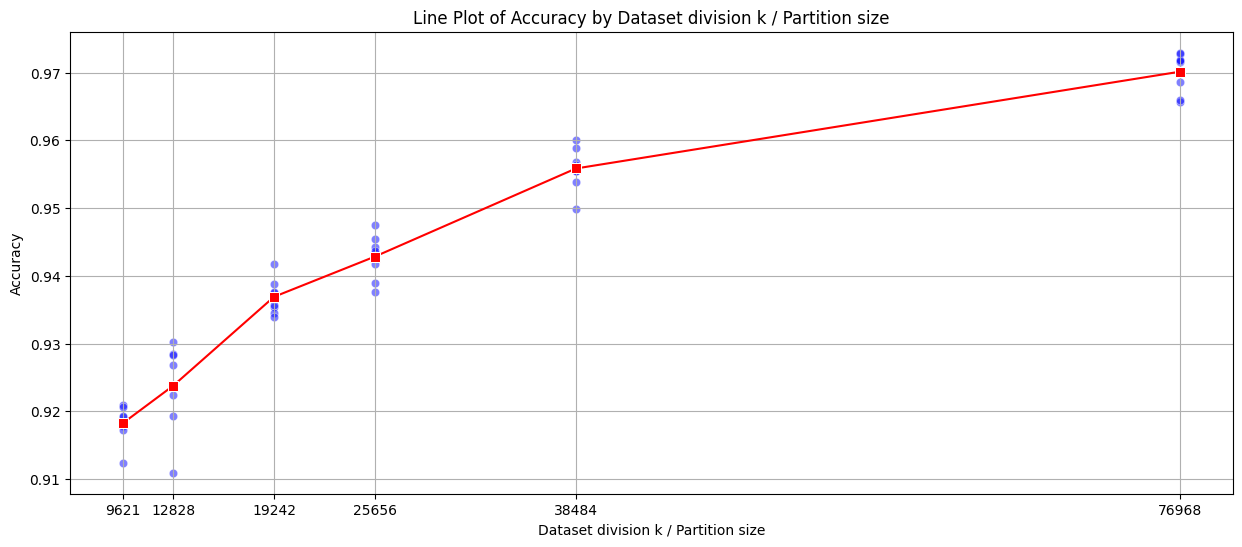

In [ ]:
plt.figure(figsize=(15, 6))

ax = sns.scatterplot(x="partition_size", y="accuracy", data=df, color='blue', marker='o', alpha=0.5)
sns.lineplot(x="partition_size", y="accuracy", data=mean_df, color='red', marker='s', markersize=7, ax=ax)

ax.set_xticks(mean_df["partition_size"])
ax.set_xticklabels(mean_df["partition_size"])
ax.grid()

plt.title("Line Plot of Accuracy by Dataset division k / Partition size")
plt.xlabel("Dataset division k / Partition size")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
######## Find the partition count with greatest accuracy variance

variance_df = df.groupby("partition_count")["accuracy"].var().reset_index()
max_variance_partition_count = variance_df.loc[variance_df["accuracy"].idxmax()][
    "partition_count"
]
df_filtered = df[df["partition_count"] == max_variance_partition_count]

print(f"Max variance at {int(max_variance_partition_count)} partition count")

Max variance at 6 partition count


### Sample printing scripts

In [ ]:
from random import randrange

import os
from os import listdir
from os.path import isfile, join

import numpy as np

from osgeo import gdal
import matplotlib.pyplot as plt

In [ ]:
def get_image_paths(base_path):
  return [ f'{base_path}/{f}' for f in listdir(base_path) if isfile(join(base_path, f))]

In [ ]:
def load_image(path):

  dataset = gdal.Open(path)

  # since there are 3 bands
  # we store in 3 different variables
  band1 = dataset.GetRasterBand(1) # Red channel
  band2 = dataset.GetRasterBand(2) # Green channel
  band3 = dataset.GetRasterBand(3) # Blue channel

  b1 = band1.ReadAsArray()
  b2 = band2.ReadAsArray()
  b3 = band3.ReadAsArray()
  img = np.dstack((b1, b2, b3))

  return img

In [ ]:
def numberOfImages(classes,base_path):
  print(f'{"Class":<24} | Images')
  print(f'-------------------------------------')

  total = 0

  for i,img_class in enumerate(classes):
    onlyfiles = get_image_paths(f'{base_path}/{img_class["dir"]}')

    print(f'{img_class["name"]:<24} | {len(onlyfiles)}')
    total+=len(onlyfiles)

  print(f'-------------------------------------')

  print(f'{"TOTAL":<24} | {total}')

In [ ]:
def printImages(classes,base_path,number_of_images=3, im_height=16, figsize=(10, 16)):
  fig, axs = plt.subplots(len(classes), number_of_images, figsize=figsize)

  for i,img_class in enumerate(classes):
    onlyfiles = get_image_paths(f'{base_path}/{img_class["dir"]}')
    for j in range(number_of_images):
      img = load_image(onlyfiles[randrange(len(onlyfiles))])
      axs[i, j].imshow(img)

      axs[i, j].set_xlabel(j + 1, fontsize="x-large")
      axs[i, j].set_ylabel(img_class["name"], rotation=0, fontsize="x-large", horizontalalignment="right", wrap=True, verticalalignment="center")


      axs[i, j].label_outer()
      # hide the axis labels
      axs[i, j].xaxis.set_tick_params(labelbottom=False)
      axs[i, j].yaxis.set_tick_params(labelleft=False)

      # Hide X and Y axes tick marks
      axs[i, j].set_xticks([])
      axs[i, j].set_yticks([])
  fig.tight_layout()

In [ ]:
def printImagesTwoDatasetComparison(classes,base_path_1,base_path_2,number_of_images=3, figsize=(10, 15)):
  fig, axs = plt.subplots(len(classes), number_of_images*2, figsize=figsize)

  for i,img_class in enumerate(classes):
    onlyfiles_1 = get_image_paths(f'{base_path_1}/{img_class["dir"]}')
    onlyfiles_2 = get_image_paths(f'{base_path_2}/{img_class["dir"]}')

    for j in range(0,(number_of_images*2)-1,2):

      image_index = randrange(len(onlyfiles_1))
      img_1 = load_image(onlyfiles_1[image_index])
      img_2 = load_image(onlyfiles_2[image_index])


      axs[i, j].imshow(img_1)
      axs[i, j].set_xlabel(f"Original {j//2+1}", fontsize="x-large")
      axs[i, j].set_ylabel(img_class["name"], rotation=0, fontsize="x-large", horizontalalignment="right", wrap=True, verticalalignment="center")

      axs[i, j].label_outer()
      # hide the axis labels
      axs[i, j].xaxis.set_tick_params(labelbottom=False)
      axs[i, j].yaxis.set_tick_params(labelleft=False)

      # Hide X and Y axes tick marks
      axs[i, j].set_xticks([])
      axs[i, j].set_yticks([])


      axs[i, j+1].imshow(img_2)
      axs[i, j+1].set_xlabel(f"Normalized {j//2+1}", fontsize="x-large")
      axs[i, j+1].set_ylabel(img_class["name"], rotation=0, fontsize="x-large", horizontalalignment="right", wrap=True, verticalalignment="center")

      axs[i, j+1].label_outer()
      # hide the axis labels
      axs[i, j+1].xaxis.set_tick_params(labelbottom=False)
      axs[i, j+1].yaxis.set_tick_params(labelleft=False)

      # Hide X and Y axes tick marks
      axs[i, j+1].set_xticks([])
      axs[i, j+1].set_yticks([])
  fig.tight_layout()

In [ ]:
classes = [
    {
        "name": "Adipose tissue",
        "dir": "ADIPOSE"
    },
    {
        "name": "Mucus",
        "dir": "MUCOSA"
    },
    {
        "name": "Smooth muscle",
        "dir": "MUS"
    },
    {
        "name": "Cancer-associated stroma",
        "dir": "STROMA"
    },
    {
        "name": "CRC epithelium",
        "dir": "TUMOR"
    },
    {
        "name": "Normal colon mucosa",
        "dir": "NORM"
    },
    {
        "name": "Lymphocytes",
        "dir": "LYMPHO"
    },
    {
        "name": "Debris",
        "dir": "DEBRIS"
    },
    {
        "name": "Background",
        "dir": "BACK"
    }
]


### Print the **best** train set samples

In [ ]:
######## Find the best from that partition count and plot some images

# Get the row with the highest accuracy
row_with_highest_accuracy = df_filtered.loc[df_filtered["accuracy"].idxmax()]

print("Row with dataset_parts=3 and highest accuracy:")
print(row_with_highest_accuracy)


partition_count = row_with_highest_accuracy["partition_count"]
iteration = row_with_highest_accuracy["iteration"]
partition = row_with_highest_accuracy["partition"]
seed = int(row_with_highest_accuracy["seed"])

Row with dataset_parts=3 and highest accuracy:
iteration              0.000000
partition_count        6.000000
partition              2.000000
seed                  53.000000
accuracy               0.930205
partition_size     12828.000000
Name: 10, dtype: float64


In [ ]:
base_path_best = "train_set_best"

In [ ]:
samples_per_partition = int(dataset_info.balanced_size / partition_count)

createSubset(
    dataset_info=dataset_info,
    destination_dir=base_path_best,
    seed=seed,
    take_samples=samples_per_partition,
    skip_samples=int(partition) * samples_per_partition,
)

numberOfImages(classes,base_path_best)

Class                    | Images
-------------------------------------
Adipose tissue           | 1425
Mucus                    | 1425
Smooth muscle            | 1425
Cancer-associated stroma | 1425
CRC epithelium           | 1425
Normal colon mucosa      | 1425
Lymphocytes              | 1425
Debris                   | 1425
Background               | 1425
-------------------------------------
TOTAL                    | 12825


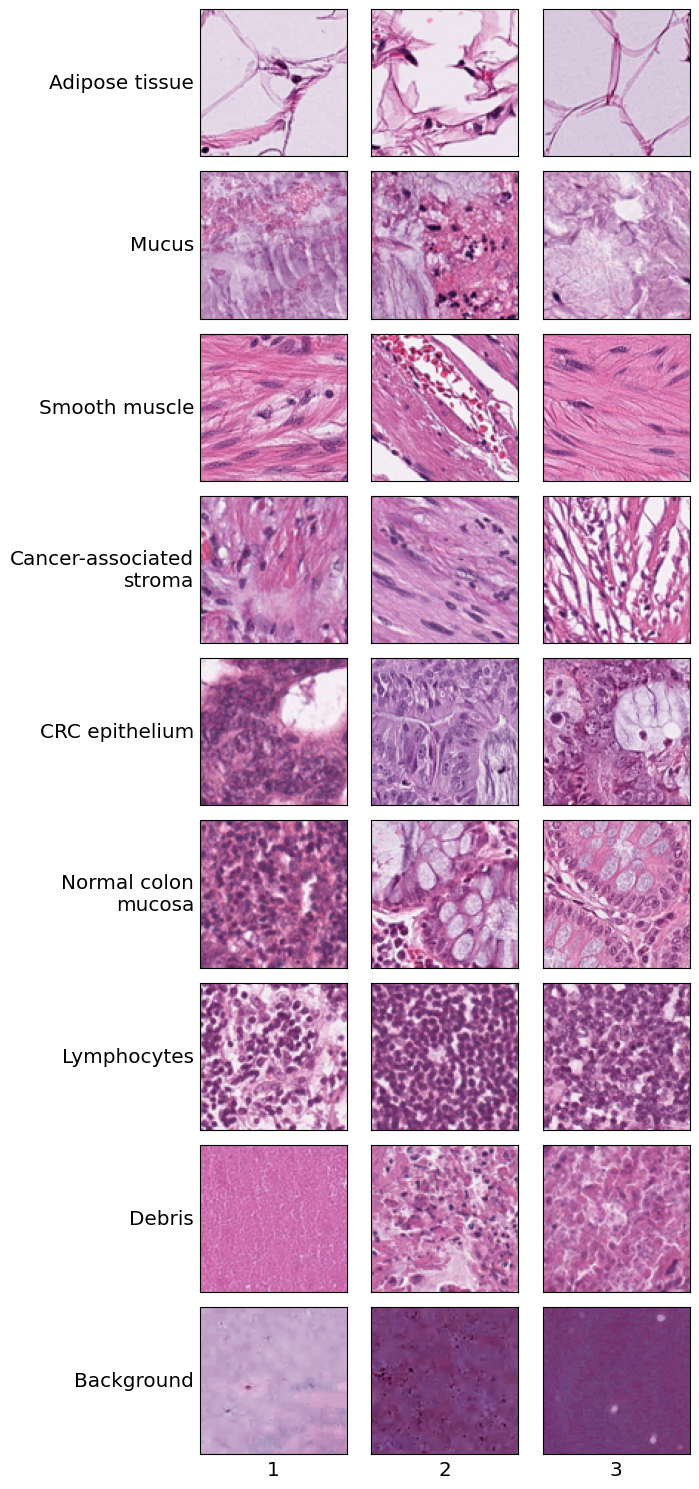

In [ ]:
printImages(classes,base_path_best, figsize=(7.5, 15))

### Print the **worst** train set samples

In [ ]:
######## Find the best from that partition count and plot some images

# Get the row with the lowest accuracy
row_with_lowest_accuracy = df_filtered.loc[df_filtered["accuracy"].idxmin()]

print("Row with dataset_parts=3 and lowest accuracy:")
print(row_with_lowest_accuracy)


partition_count = row_with_lowest_accuracy["partition_count"]
iteration = row_with_lowest_accuracy["iteration"]
partition = row_with_lowest_accuracy["partition"]
seed = int(row_with_lowest_accuracy["seed"])

Row with dataset_parts=3 and lowest accuracy:
iteration              0.000000
partition_count        6.000000
partition              1.000000
seed                  53.000000
accuracy               0.910948
partition_size     12828.000000
Name: 9, dtype: float64


In [ ]:
base_path_worst = "train_set_worst"

In [ ]:
samples_per_partition = int(dataset_info.balanced_size / partition_count)

createSubset(
    dataset_info=dataset_info,
    destination_dir=base_path_worst,
    seed=seed,
    take_samples=samples_per_partition,
    skip_samples=int(partition) * samples_per_partition,
)

numberOfImages(classes,base_path_best)

Class                    | Images
-------------------------------------
Adipose tissue           | 1425
Mucus                    | 1425
Smooth muscle            | 1425
Cancer-associated stroma | 1425
CRC epithelium           | 1425
Normal colon mucosa      | 1425
Lymphocytes              | 1425
Debris                   | 1425
Background               | 1425
-------------------------------------
TOTAL                    | 12825


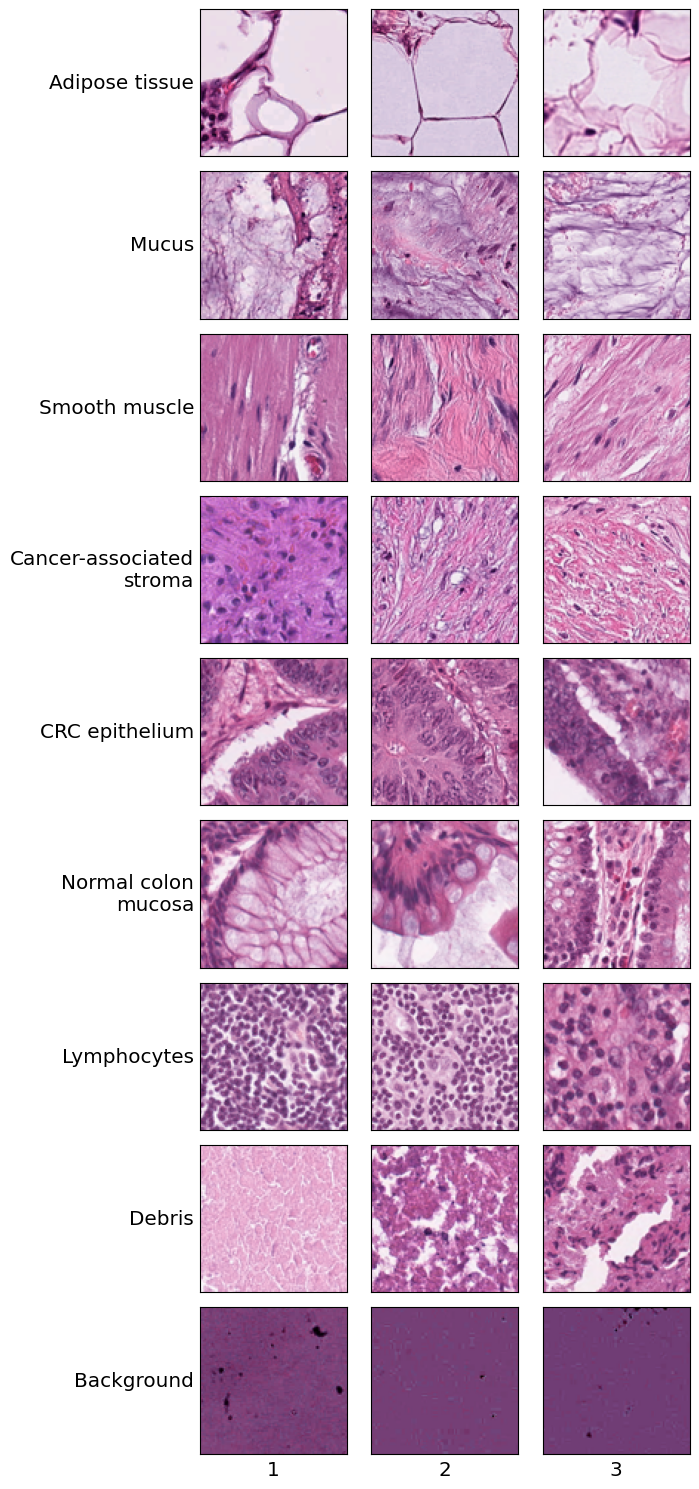

In [ ]:
printImages(classes,base_path_worst, figsize=(7.5, 15))

### Compare ratio of datasets inside best and worst set

In [ ]:
import re

In [ ]:
def list_all_files(directory):
    all_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            all_files.append(file)
    return all_files


files_best = list_all_files(base_path_best)
files_worst = list_all_files(base_path_worst)
files_test = list_all_files("test_set")



files_best_k16 = sum(1 for item in files_best if re.search(r'.*\.tif_Row_.*', item))
files_best_k19 = sum(1 for item in files_best if not re.search(r'.*\.tif_Row_.*', item))

files_worst_k16 = sum(1 for item in files_worst if re.search(r'.*\.tif_Row_.*', item))
files_worst_k19 = sum(1 for item in files_worst if not re.search(r'.*\.tif_Row_.*', item))

files_test_k16 = sum(1 for item in files_test if re.search(r'.*\.tif_Row_.*', item))
files_test_k19 = sum(1 for item in files_test if not re.search(r'.*\.tif_Row_.*', item))

print(f"""
##### Best training set #####
Kather (2016) = {files_best_k16}
Kather (2019) = {files_best_k19}
Kather (2016) vs Kather (2019) = {files_best_k16/(files_best_k16+files_best_k19) * 100:.2f}%

##### Worst training set #####
Kather (2016) = {files_worst_k16}
Kather (2019) = {files_worst_k19}
Kather (2016) vs Kather (2019) = {files_worst_k16/(files_worst_k16+files_worst_k19) * 100:.2f}%

##### Test set #####
Kather (2016) = {files_test_k16}
Kather (2019) = {files_test_k19}
Kather (2016) vs Kather (2019) = {files_test_k16/(files_test_k16+files_test_k19) * 100:.2f}%
""")


##### Best training set #####
Kather (2016) = 430
Kather (2019) = 12395
Kather (2016) vs Kather (2019) = 3.35%

##### Worst training set #####
Kather (2016) = 447
Kather (2019) = 12378
Kather (2016) vs Kather (2019) = 3.49%

##### Test set #####
Kather (2016) = 282
Kather (2019) = 8286
Kather (2016) vs Kather (2019) = 3.29%



434 - 414 = 20   =>  Premala razlika između omjera setova best i worst

trebalo bi gledati i test set koliki je tu omjer pa po tome raditi usporedbu, ali svakako je premala razlika u omjerima u trening setovima

# Iterative V2 - Single test set per division - Incomplete

In [ ]:
import keras
import os
from fractions import Fraction
import tensorflow as tf
import random

import save
import model_builder
from directory_balancer import DirectoryInfo, createSubset
import gc

gc.enable()
gc.isenabled()

########## Configuration part ##########

# - dimenzija manjeg dataseta
dataset_small_samples_total = 5000 - 2 * 625

# - direktorij merganog dataseta
dataset_dir = f"{os.environ['COLAB_DATA_DIR']}/{os.environ['DATASET']}/"

# ------- Optional configuration --------

image_size = 100, 100
N_min = 1  # Define minium number of iterations per division
split = 0.2  # Train / Test
epoch_counts = [5, 5]
seed = 123

results_dir = f"{os.environ['DRIVE_DATA_DIR']}/iterative_results/"

batch_size = 32
model_name = "MobileNetV2"
dataset_name = "merged_dataset"  # os.environ['DATASET']
image_format = "png"  # os.environ['IMAGE_FORMAT']

phase1optimizer = "RMSprop"
phase2optimizer = "RMSprop"


def phase_1_optimizer():
    return keras.optimizers.RMSprop()


def phase_2_optimizer():
    return keras.optimizers.RMSprop(1e-5)


######### Initialization part  #########

results_output = f"""\
{results_dir}\
{model_name}-{dataset_name}-\
{image_format}-{image_size[0]}x{image_size[1]}-\
{batch_size}-{phase1optimizer}+{phase2optimizer}-\
{split}:{100-split}-all.csv"""

dataset_dir = f"{os.environ['COLAB_DATA_DIR']}/{os.environ['DATASET']}/"
dataset_dir_balanced = (
    f"{os.environ['COLAB_DATA_DIR']}/{os.environ['DATASET']}-balanced/"
)

dataset_info = DirectoryInfo(dataset_dir)

labels_count = tf.convert_to_tensor(
    dataset_info.number_of_classes, dtype=tf.int32
)  # https://stackoverflow.com/a/58973855/12108610

K = [
    k
    for len in range(dataset_info.balanced_size)
    for k in range(40)
    if (k + 0.2) * len == dataset_info.balanced_size
]

iterations_max = N_min * K[0]

print(f"Factors number = {len(K)}:\t {K}\n")
for k in K:
    print(f"""\
    k = {k} => ({k} + 0.2) x {dataset_info.balanced_size/(k+0.2)} = {dataset_info.balanced_size}\
    Iterations: {(iterations_max)//k} + Extra remainder: {(iterations_max)%k}\
    """)

random_local = random.Random(seed)
randomPairs = list(zip(*[iter(random_local.sample(range(0, 1000), len(K) * 2))] * 2))
print(f"\nRandom pairs: {randomPairs}")

######### Train and test part  #########

for partition_count, random_pair in zip(K, randomPairs):
    samples_per_subset = int(dataset_info.balanced_size / (partition_count + 0.2))

    samples_in_test_set = dataset_info.balanced_size - samples_per_subset * partition_count

    print(
        f"\033[92m #### Partition count {partition_count} : seeds {random_pair} #### \033[0m"
    )
    print(
        f"samples_per_subset: {samples_per_subset} \t samples_in_test_set: {samples_in_test_set}"
    )

    # if partition_count in K[:5]:
    #     print(f"Skipping partition count #{partition_count}")
    #     continue

    subset_test = keras.utils.image_dataset_from_directory(
        createSubset(
            dataset_info,
            "test_set",
            samples_in_test_set,
            seed=random_pair[0],
            skip_samples=0,
        ),
        labels="inferred",
        label_mode="int",
        color_mode="rgb",
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True,
        seed=random_pair[0],
        crop_to_aspect_ratio=False,
    )

    for partition in range(partition_count + iterations_max % partition_count):
        print(f"Partition {partition+1}/{partition_count}")
        # if partition_count == 3 and partition in [0]:
        #   print(f"Skipping partition count #{partition_count} partition #{partition}")
        #   continue
        notRemainder = True
        seed = random_pair[0]
        if partition >= partition_count:
            print(
                f"    Remainder {(partition % partition_count)+1}/{iterations_max % partition_count}"
            )
            notRemainder = False
            seed = random_pair[1]

        subset_train = keras.utils.image_dataset_from_directory(
            createSubset(
                dataset_info,
                "train_set",
                samples_per_subset,
                seed=seed,
                skip_samples=(
                    samples_in_test_set + partition * samples_per_subset
                    if notRemainder
                    else (partition % partition_count) * samples_per_subset # TODO: we forget to omit the samples used in test set
                ),
                # Omit test samples during new train distribution generation
                seed_omit=None if notRemainder else random_pair[0],
                samples_omit=0 if notRemainder else samples_in_test_set,
            ),
            labels="inferred",
            label_mode="int",
            color_mode="rgb",
            batch_size=batch_size,
            image_size=image_size,
            shuffle=True,
            seed=seed,
            crop_to_aspect_ratio=False,
        )

        accuracy = model_builder.create_model_and_train(
            subset_train,
            subset_test,
            image_size,
            epoch_counts,
            phase_1_optimizer,
            phase_2_optimizer,
            labels_count,
        )

        save.saveResults(
            partition_count,
            partition,
            seed,
            accuracy,
            results_output,
        )


# Iterative V3 - Different test set for each partition - Incomplete

In [ ]:
import keras
import os
import tensorflow as tf
from fractions import Fraction
import gc
import random

import save
import helper
import model_builder
from directory_balancer import DirectoryInfo, createSubset

gc.enable()
gc.isenabled()

########## Configuration part ##########

# - dimenzija manjeg dataseta
dataset_small_samples_total = 5000 - 2 * 625

# - direktorij merganog dataseta
dataset_dir = f"{os.environ['COLAB_DATA_DIR']}/{os.environ['DATASET']}/"

# ------- Optional configuration --------

image_size = 100, 100
N_min = 1  # Define minium number of iterations per division
split = 80  # Train / Test
epoch_counts = [5, 5]
seed = 123

results_dir = f"{os.environ['DRIVE_DATA_DIR']}/iterative_results/"

batch_size = 32
model_name = "MobileNetV2"
dataset_name = "merged_dataset"  # os.environ['DATASET']
image_format = "png"  # os.environ['IMAGE_FORMAT']

phase1optimizer = "RMSprop"
phase2optimizer = "RMSprop"


def phase_1_optimizer():
    return keras.optimizers.RMSprop()


def phase_2_optimizer():
    return keras.optimizers.RMSprop(1e-5)


######### Initialization part  #########

results_output = f"""\
{results_dir}\
{model_name}-{dataset_name}-\
{image_format}-{image_size[0]}x{image_size[1]}-\
{batch_size}-{phase1optimizer}+{phase2optimizer}-\
{split}:{100-split}-v2.csv"""


dataset_info = DirectoryInfo(dataset_dir)


k_max = dataset_info.balanced_size // dataset_small_samples_total  # Greatest dividor
K = helper.get_all_divisors_less_than(dataset_info.balanced_size, k_max)
iterations_max = N_min * K[0]

print(
    f"k_max = round({dataset_info.balanced_size} / {dataset_small_samples_total}) = {k_max}"
)
print(f"Factors of {dataset_info.balanced_size}, <= {k_max} = |{len(K)}|:\t {K}\n")


for k in K:
    print(f"""\
    k = {k:2.0f} => {k:2.0f} x {(dataset_info.balanced_size//k):5.0f} = {k*(dataset_info.balanced_size//k)}\
    Iterations: {(iterations_max//k):2.0f} Extra remainder: {(iterations_max%k):2.0f}\
    """)


######### Train and test part  #########

random_local = random.Random(seed)
random_seeds = random_local.sample(range(0, 1000), iterations_max)
print(f"\nRandom pairs: {random_seeds}")

labels_count = tf.convert_to_tensor(
    dataset_info.number_of_classes, dtype=tf.int32
)  # https://stackoverflow.com/a/58973855/12108610


for iteration, seed in zip(range(iterations_max), random_seeds):
    print(f"\033[92m #### Iteration {iteration} : seed {seed} #### \033[0m")
    # if iteration in range(6):
    #     print(f"Skipping partition count #{iteration}")
    #     continue

    for partition_count in K:
        # if partition_count in [22, 18, 16, 12, 11, 9, 8, 6, 4]:
        #   print(f"Skipping partition count {partition_count}")
        #   continue

        if iterations_max / partition_count > iteration:
            samples_per_partition = int(dataset_info.balanced_size / partition_count)

            real_partition_count = (
                partition_count
                if iterations_max // partition_count > iteration
                else iterations_max % partition_count
            )

            for partition in range(real_partition_count):
                print(f"Partition {partition+1}/{partition_count}")

                # if partition_count == 3 and partition in [0]:
                #   print(f"Skipping partition count {partition_count} partition {partition}")
                #   continue

                train_subset_size = (
                    Fraction(split, 100).numerator * samples_per_partition
                ) // Fraction(split, 100).denominator
                test_subset_size = (
                    Fraction(split, 100).numerator * samples_per_partition
                ) // Fraction(split, 100).denominator

                print(
                    f"Check partition train/test split: {train_subset_size} + {test_subset_size} == {samples_per_partition} -> {train_subset_size+test_subset_size==samples_per_partition} "
                )

                subset_train = keras.utils.image_dataset_from_directory(
                    createSubset(
                        dataset_info=dataset_info,
                        destination_dir="test_set",
                        seed=seed,
                        take_samples=train_subset_size,
                        skip_samples=partition * samples_per_partition,
                    ),
                    labels="inferred",
                    label_mode="int",
                    color_mode="rgb",
                    batch_size=batch_size,
                    image_size=image_size,
                    shuffle=True,
                    seed=seed,
                    crop_to_aspect_ratio=False,
                )

                subset_test = keras.utils.image_dataset_from_directory(
                    createSubset(
                        dataset_info=dataset_info,
                        destination_dir="train_set",
                        seed=seed,
                        take_samples=test_subset_size,
                        skip_samples=partition * samples_per_partition, # Check this, maybe following is correct: partition * samples_per_partition + train_subset_size
                    ),
                    labels="inferred",
                    label_mode="int",
                    color_mode="rgb",
                    batch_size=batch_size,
                    image_size=image_size,
                    shuffle=True,
                    seed=seed,
                    crop_to_aspect_ratio=False,
                )

                accuracy = model_builder.create_model_and_train(
                    subset_train,
                    subset_test,
                    image_size,
                    epoch_counts,
                    phase_1_optimizer,
                    phase_2_optimizer,
                    labels_count,
                )

                # train && evaluate
                save.saveResults(
                    iteration,
                    partition_count,
                    partition,
                    seed,
                    accuracy,
                    results_output,
                )
